In [27]:
""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import percephone.core.recording as pc
import percephone.plts.behavior as pbh
import percephone.plts.stats as ppt
import percephone.analysis.mlr_models as mlr_m
import numpy as np
import pandas as pd
import scipy.stats as ss
from multiprocessing import Pool, cpu_count, pool
import os
import matplotlib
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.formula.api import ols
import matplotlib as mpl


plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
save_figure = True

In [28]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
    server_address = "Z:/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    server_address = "/run/user/1004/gvfs/smb-share:server=engram.local,share=data/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Adrien":
    directory = "C:/Users/acorniere/Desktop/percephone_data/"
    roi_path = directory + "FmKO_ROIs&inhibitory.xlsx"

roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
   pool = Pool(processes=workers)
elif user == "Adrien":
    pool = pool.ThreadPool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

In [29]:
def fraction_resp(pattern, n_type, ko_hypo_only=True, stim_ampl="all", no_go_normalize=True):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        no_go_filter = rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_no_go = resp_mat[:, no_go_filter]
        trials_detected = resp_mat[:, ampl_det_filt]
        trials_undetected = resp_mat[:, ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
            trials_no_go[trials_no_go!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0
            trials_no_go[trials_no_go!=pattern]=0
        
        # The total number of neurons is computed
        total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
        
        # Computation of the number of responsive neurons
        recruited_det = np.mean(np.count_nonzero(trials_detected, axis=0))
        recruited_undet = np.mean(np.count_nonzero(trials_undetected, axis=0))
        
        # Normalization by the number of responsive neurons for no-go trials
        if no_go_normalize:
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go, axis=0))
            recruited_det -= recruited_no_go
            recruited_undet -= recruited_no_go
            recruited_det = 0 if recruited_det < 0 else recruited_det
            recruited_undet = 0 if recruited_undet < 0 else recruited_undet
        
        # Computation of the percentage of responsive neurons
        perc_n_det = (recruited_det/total_n)*100
        perc_n_undet = (recruited_undet/total_n)*100
        
        # Storing the computed percentage in the corresponding list
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
        elif rec.genotype == "KO" and not ko_hypo_only:
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    return np.array(wt_det), np.array(ko_det), np.array(wt_undet), np.array(ko_undet)

In [30]:
def plot_neuron_frac_wt_ko(pattern, ko_hypo_only=True, stim_ampl="all", ylim=[], no_go_normalize=True):
    if ko_hypo_only:
        ko_type = "KO-Hypo"
        color_ko = ppt.hypo_color
        light_color_ko = ppt.hypo_light_color
    else:
        ko_type = "(KO + KO-Hypo)"
        color_ko = ppt.all_ko_color
        light_color_ko = ppt.all_ko_light_color
        
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    for y_index, n_type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type=n_type, ko_hypo_only=ko_hypo_only, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
        ppt.boxplot(axs[y_index, 0], wt_det, ko_det, paired=False, ylabel="Neurons(%)", title=f"{n_type} Detected", ylim=ylim, 
                    colors=[ppt.wt_color, color_ko], det_marker=True)
        ppt.boxplot(axs[y_index, 1], wt_undet, ko_undet, paired=False, ylabel="Neurons(%)", title=f"{n_type} Undetected", ylim=ylim, 
                    colors=[ppt.wt_light_color, light_color_ko], det_marker=False)

    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Percentage of neurons {t_pattern} during hit and miss trials (amplitude: {stim_ampl}) - WT vs. {ko_type}", fontsize=5)
    fig.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/fr_n_{t_pattern}_{stim_ampl}.pdf"
        fig.savefig(server_address + title)

# Comparison WT vs Ko-Hypo

## Fraction of neurons recruited ( 1 and -1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8963662266692436, pvalue=0.23168374014698145)
ShapiroResult(statistic=0.8660045074275656, pvalue=0.17120545790456587)
LeveneResult(statistic=0.8148700384395667, pvalue=0.38195339825932806)
Equal variances :TtestResult(statistic=1.9321997464460925, pvalue=0.07382774403281764, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7021723577219326, pvalue=0.0015046081491658665)
ShapiroResult(statistic=0.8234964912105932, pvalue=0.0693785718777728)
MannwhitneyuResult(statistic=37.0, pvalue=0.5911188975011942)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7616268490155889, pvalue=0.00739245951146654)
ShapiroResult(statistic=0.8700614104218866, pvalue=0.18585759117716477)
MannwhitneyuResult(statistic=41.5, pvalue=0.3142583667221204)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5276301238642018, pvalue=1.3511595234788798e-05)
ShapiroResult(statistic=0.7733777220361945, pvalue=0.

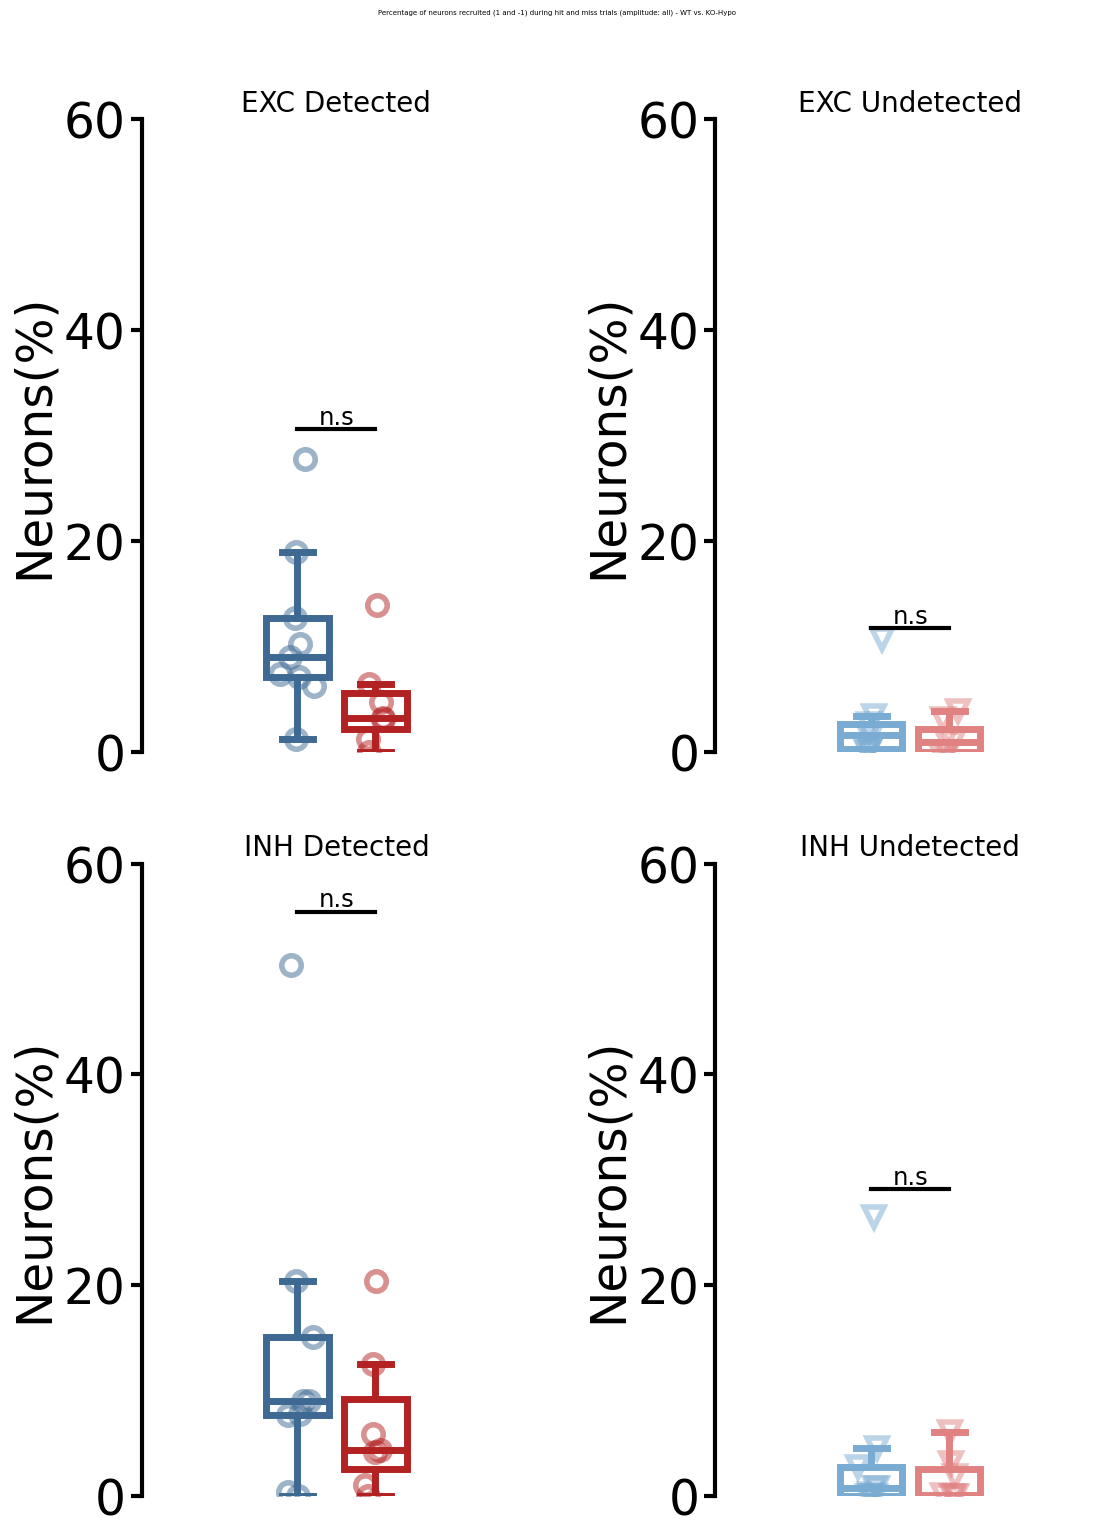

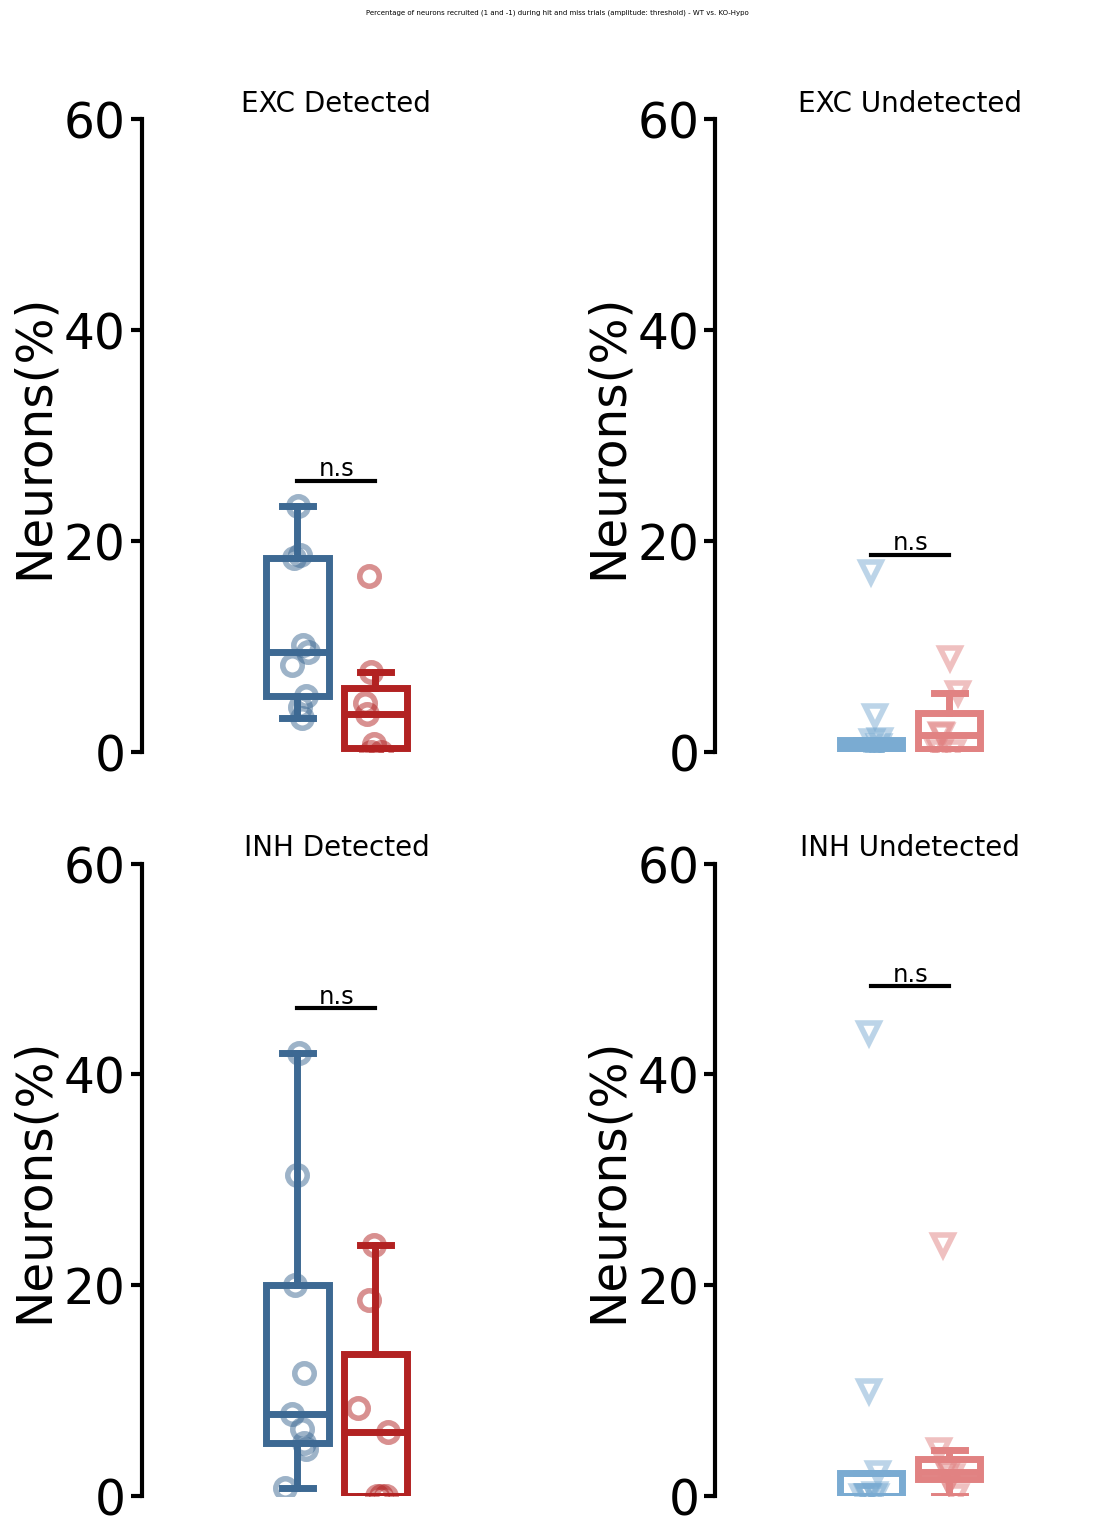

In [31]:
plot_neuron_frac_wt_ko(pattern=0, ko_hypo_only=True, stim_ampl="all", no_go_normalize=True, ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko_hypo_only=True, stim_ampl="threshold", no_go_normalize=True, ylim=[0, 60])

## Fraction of neurons activated (1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9715886255071312, pvalue=0.9079640372756269)
ShapiroResult(statistic=0.7312187702483861, pvalue=0.008043278218586483)
MannwhitneyuResult(statistic=47.0, pvalue=0.11416083916083916)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.863747723217491, pvalue=0.10529506103779052)
ShapiroResult(statistic=0.810150556870984, pvalue=0.051542279826455324)
LeveneResult(statistic=0.03773484989452005, pvalue=0.8487670378326845)
Equal variances :TtestResult(statistic=0.31436465111943246, pvalue=0.7578799866071799, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8397393690521138, pvalue=0.05737013972212317)
ShapiroResult(statistic=0.9679615092664401, pvalue=0.8833897122063161)
LeveneResult(statistic=1.9328775492843875, pvalue=0.1861524472416812)
Equal variances :TtestResult(statistic=1.1778814514681955, pvalue=0.2584790556259059, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8

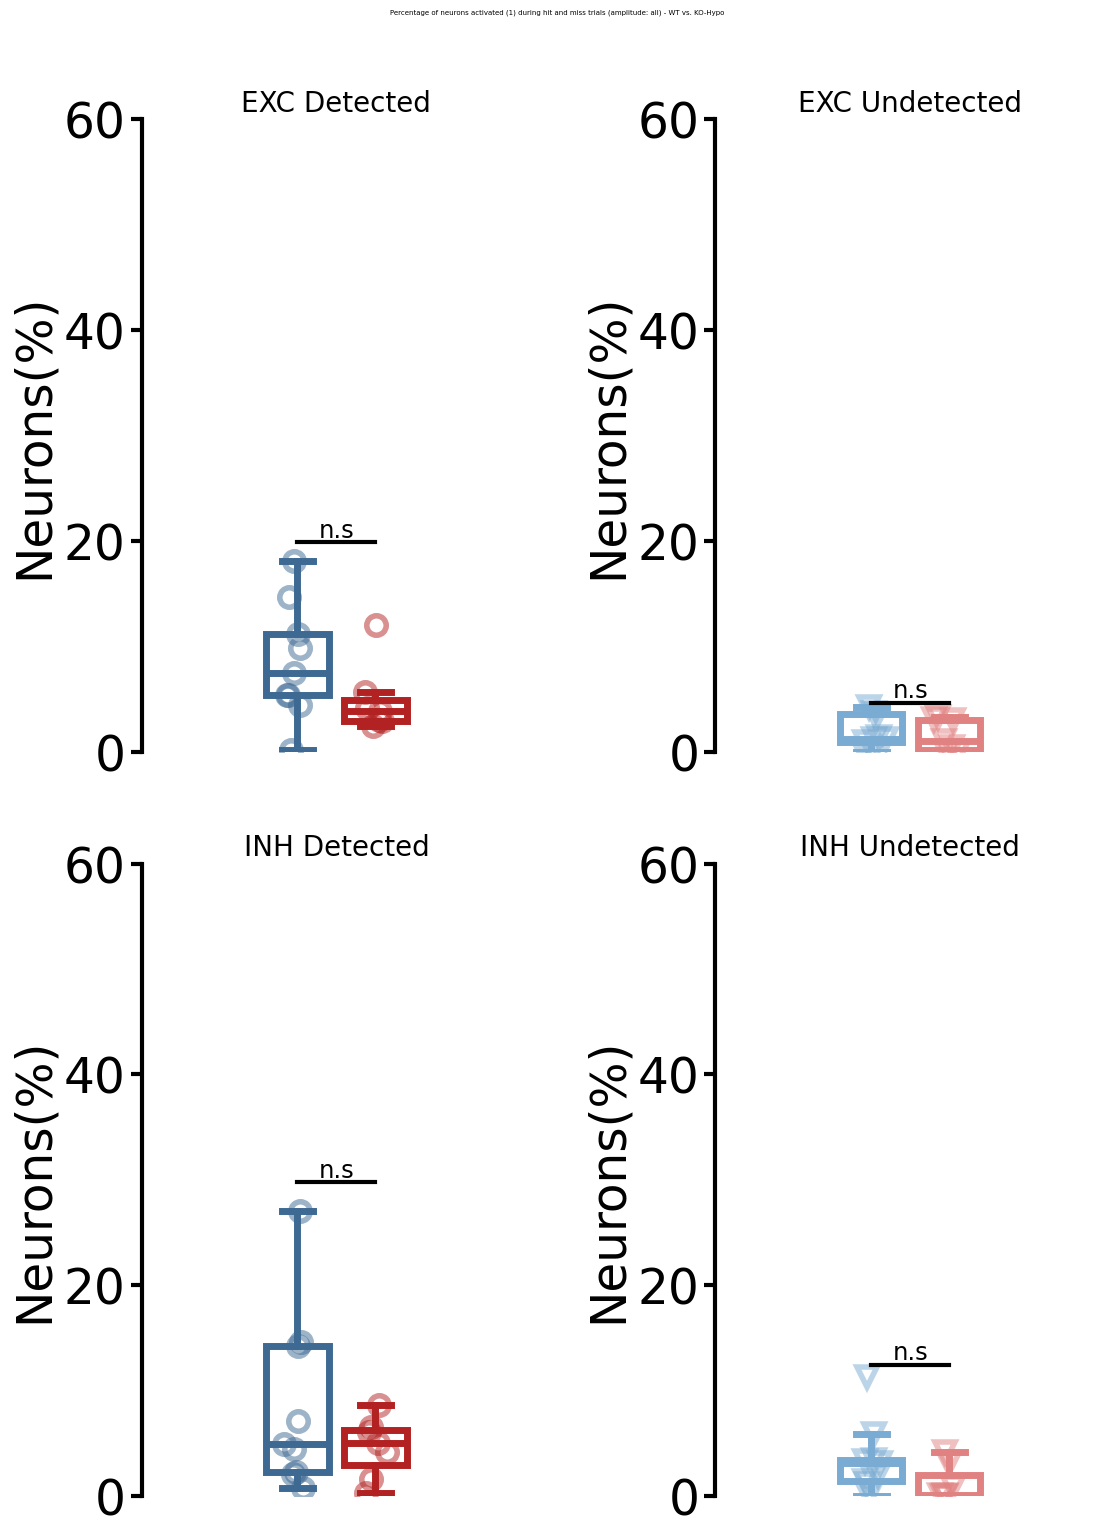

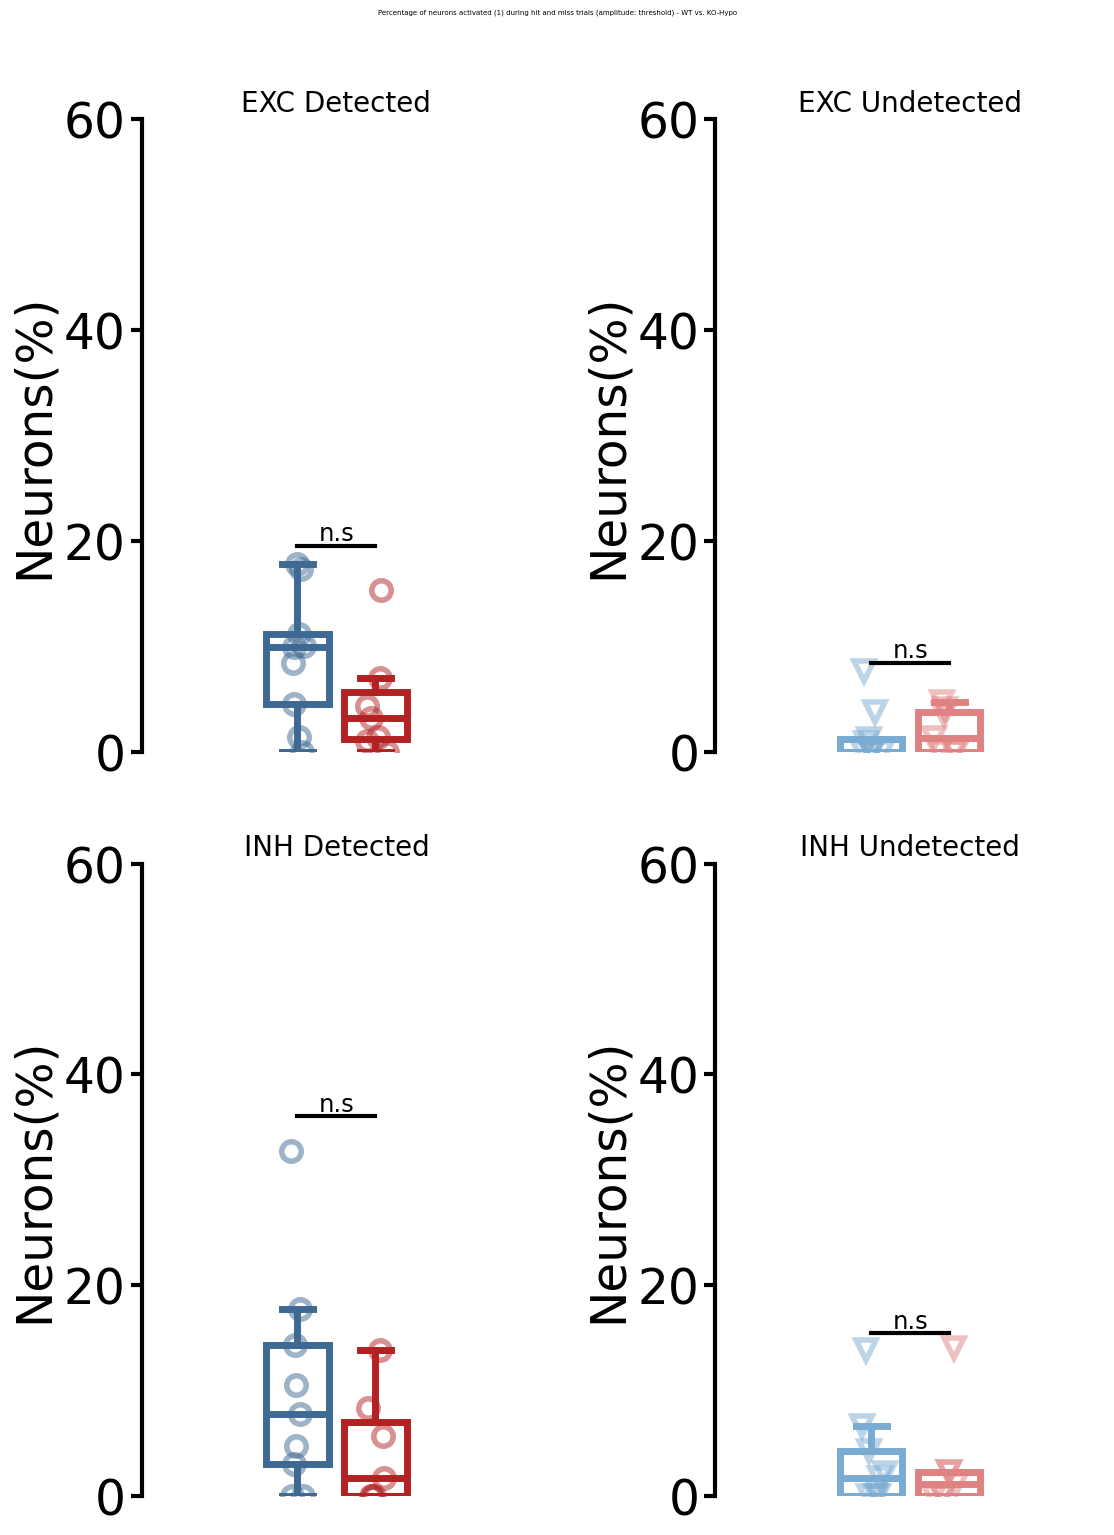

In [32]:
plot_neuron_frac_wt_ko(pattern=1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5697065884454251, pvalue=4.218349212648518e-05)
ShapiroResult(statistic=0.7549016184047022, pvalue=0.014271663635000379)
MannwhitneyuResult(statistic=42.5, pvalue=0.2537888660005908)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.47671476709066385, pvalue=3.4019071837248674e-06)
ShapiroResult(statistic=0.7941756942214614, pvalue=0.03585730503511788)
MannwhitneyuResult(statistic=32.5, pvalue=0.9549177065523541)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6033457785090619, pvalue=0.00010473030174722723)
ShapiroResult(statistic=0.5817495617994556, pvalue=0.00016557480473705546)
MannwhitneyuResult(statistic=42.5, pvalue=0.23515669100197867)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.4580979939042771, pvalue=2.053508891992133e-06)
ShapiroResult(statistic=0.6135252153514845, pvalue=0.00039190819724697315)
MannwhitneyuResult(statistic=32.0, pvalue=1.0)
Boxplot plotting.
--- Ne

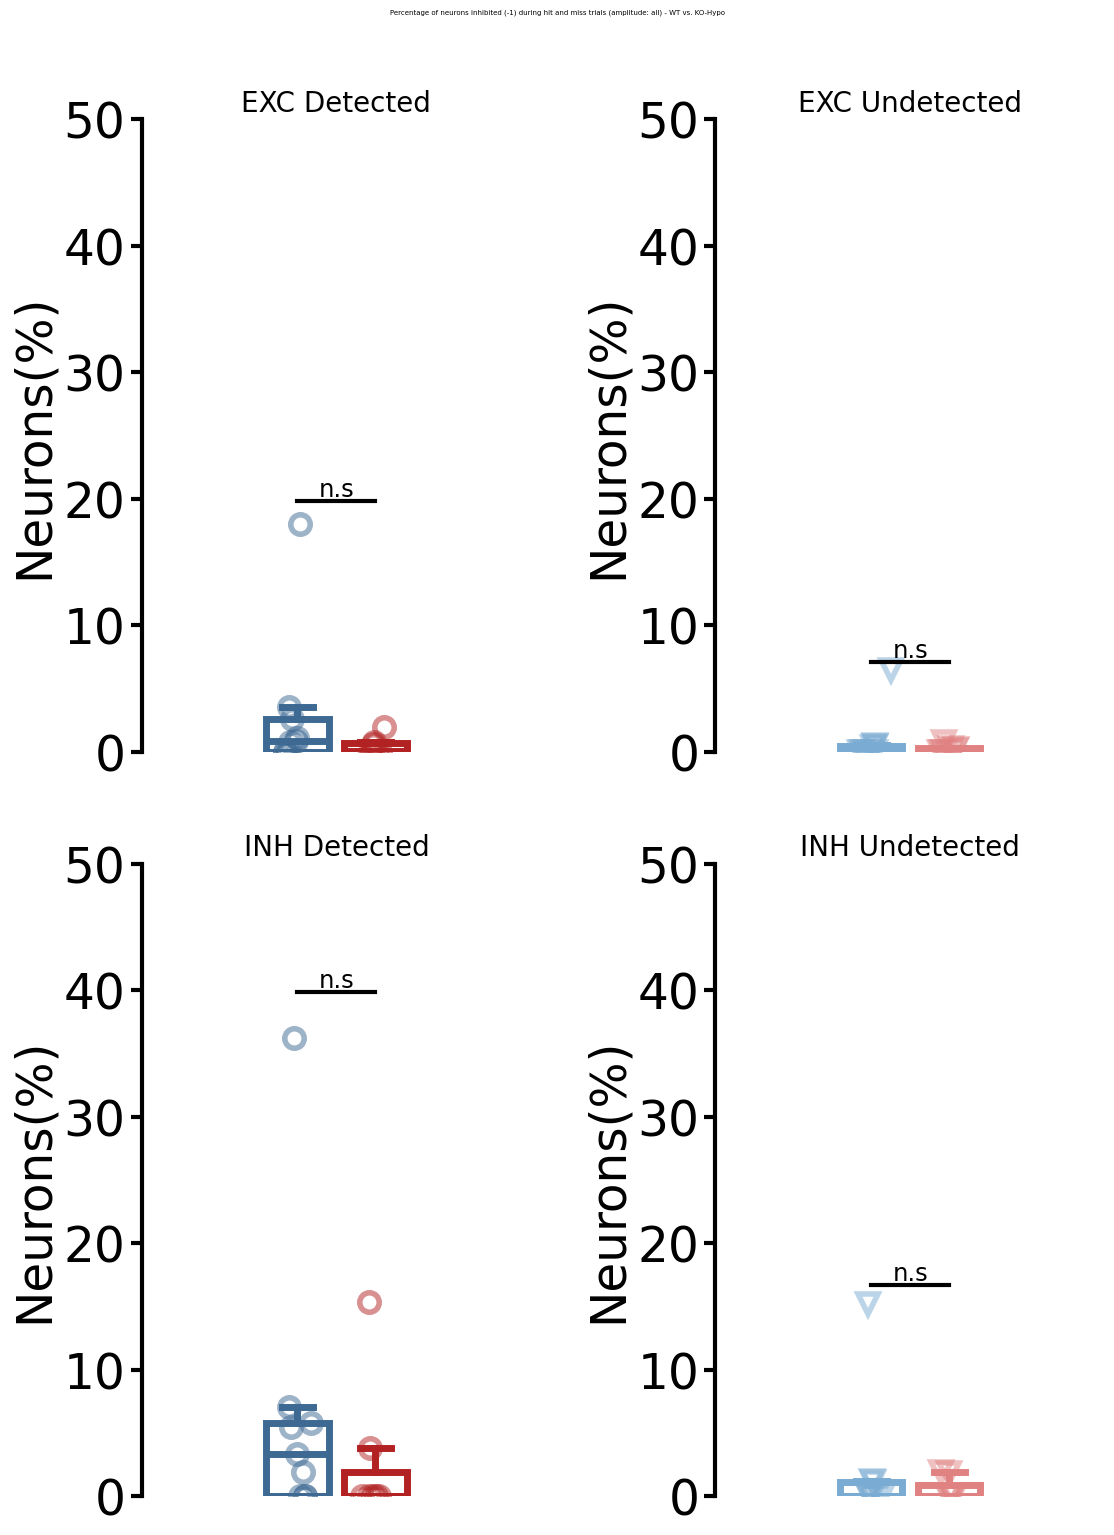

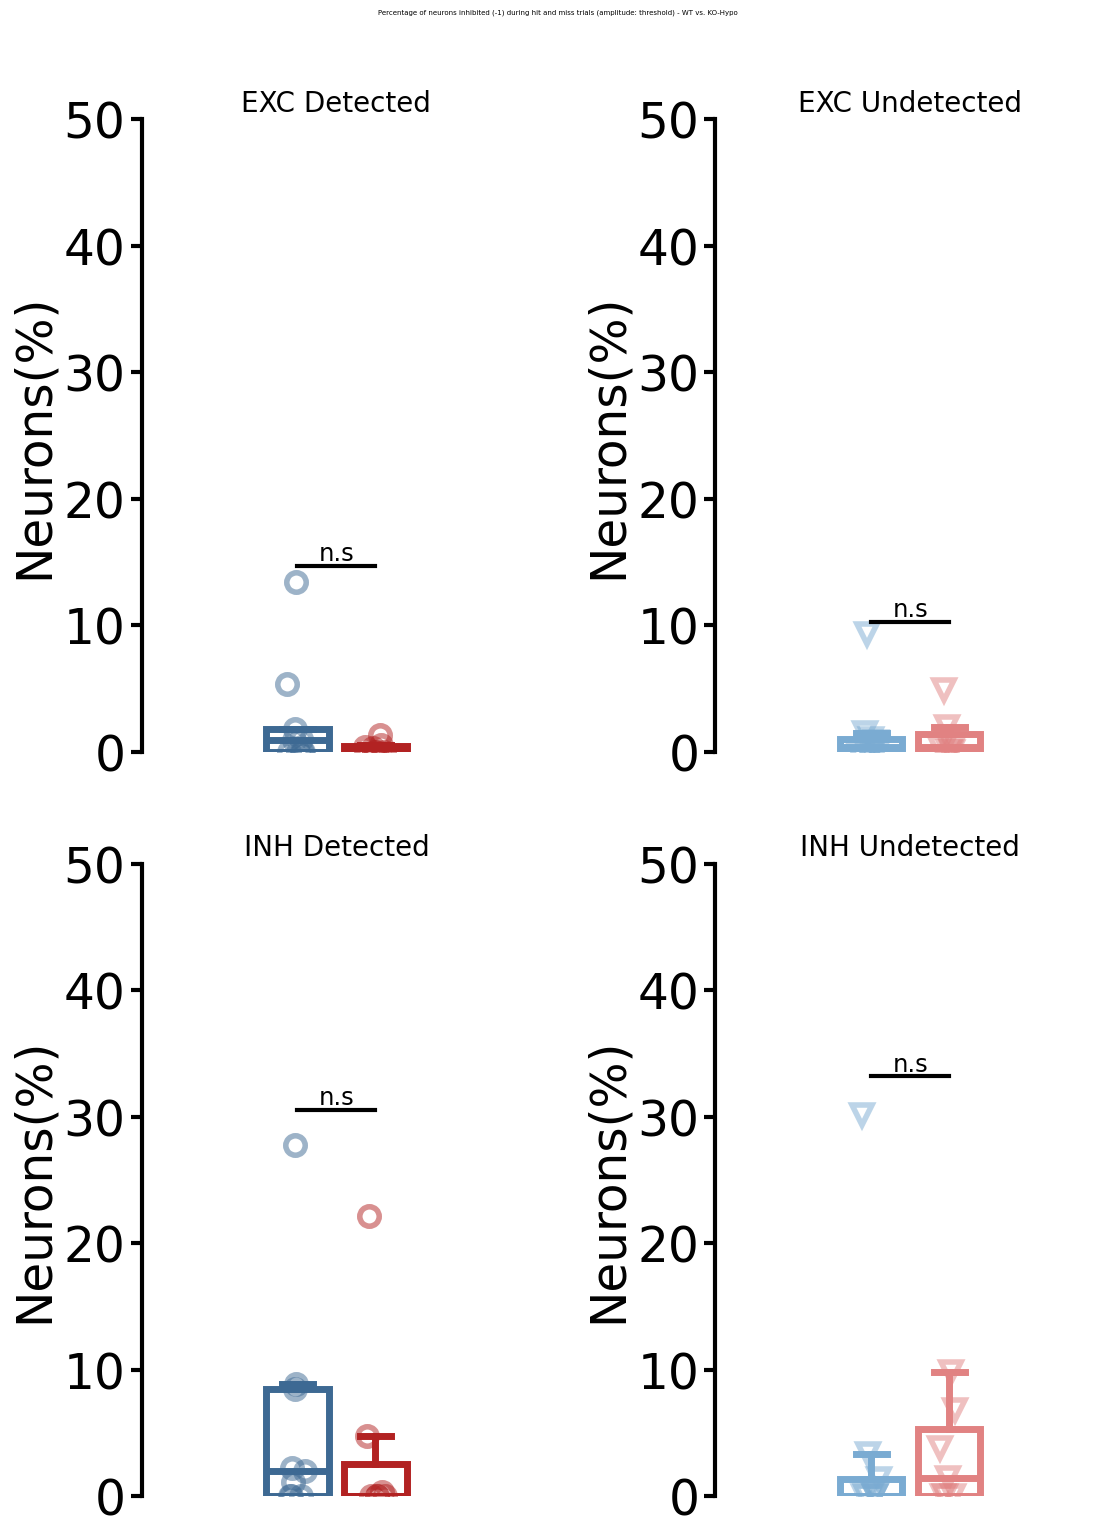

In [33]:
plot_neuron_frac_wt_ko(pattern=-1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="all", ylim=[0, 50])
plot_neuron_frac_wt_ko(pattern=-1, ko_hypo_only=True, no_go_normalize=True, stim_ampl="threshold", ylim=[0, 50])

# Comparison group det vs group undet


## Fraction of neurons recruited (1 and -1)

In [34]:
def plot_neuron_frac_det_undet(pattern, ko_hypo_only=True, stim_ampl="all", ylim=[], no_go_normalize=True):
    if ko_hypo_only:
        ko_type = "KO-Hypo"
        color_ko = ppt.hypo_color
        light_color_ko = ppt.hypo_light_color
    else:
        ko_type = "(KO + KO-Hypo)"
        color_ko = ppt.all_ko_color
        light_color_ko = ppt.all_ko_light_color
        
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    for y_index, n_type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type=n_type, ko_hypo_only=ko_hypo_only, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
        ppt.boxplot(axs[y_index, 0], wt_det, wt_undet, paired=True, ylabel="Neurons(%)", title=f"{n_type} - WT", ylim=ylim, 
                    colors=[ppt.wt_color, ppt.wt_light_color])
        ppt.boxplot(axs[y_index, 1], ko_det, ko_undet, paired=True, ylabel="Neurons(%)", title=f"{n_type} - {ko_type}", ylim=ylim, 
                    colors=[color_ko, light_color_ko])

    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Comparison of neurons {t_pattern} between hit and miss trials (amplitude: {stim_ampl}) - WT & {ko_type}", fontsize=5)
    fig.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/paired_fr_n_{t_pattern}_{stim_ampl}.pdf"
        fig.savefig(server_address + title)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8963662266692436, pvalue=0.23168374014698145)
ShapiroResult(statistic=0.7021723577219326, pvalue=0.0015046081491658665)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8660045074275656, pvalue=0.17120545790456587)
ShapiroResult(statistic=0.8234964912105932, pvalue=0.0693785718777728)
TtestResult(statistic=2.3845153127347594, pvalue=0.05443183415299142, df=6)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7616268490155889, pvalue=0.00739245951146654)
ShapiroResult(statistic=0.5276301238642018, pvalue=1.3511595234788798e-05)
WilcoxonResult(statistic=2.0, pvalue=0.01171875)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8700614104218866, pvalue=0.18585759117716477)
ShapiroResult(statistic=0.7733777220361945, pvalue=0.022121454494750274)
WilcoxonResult(statistic=3.0, pvalue=0.078125)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


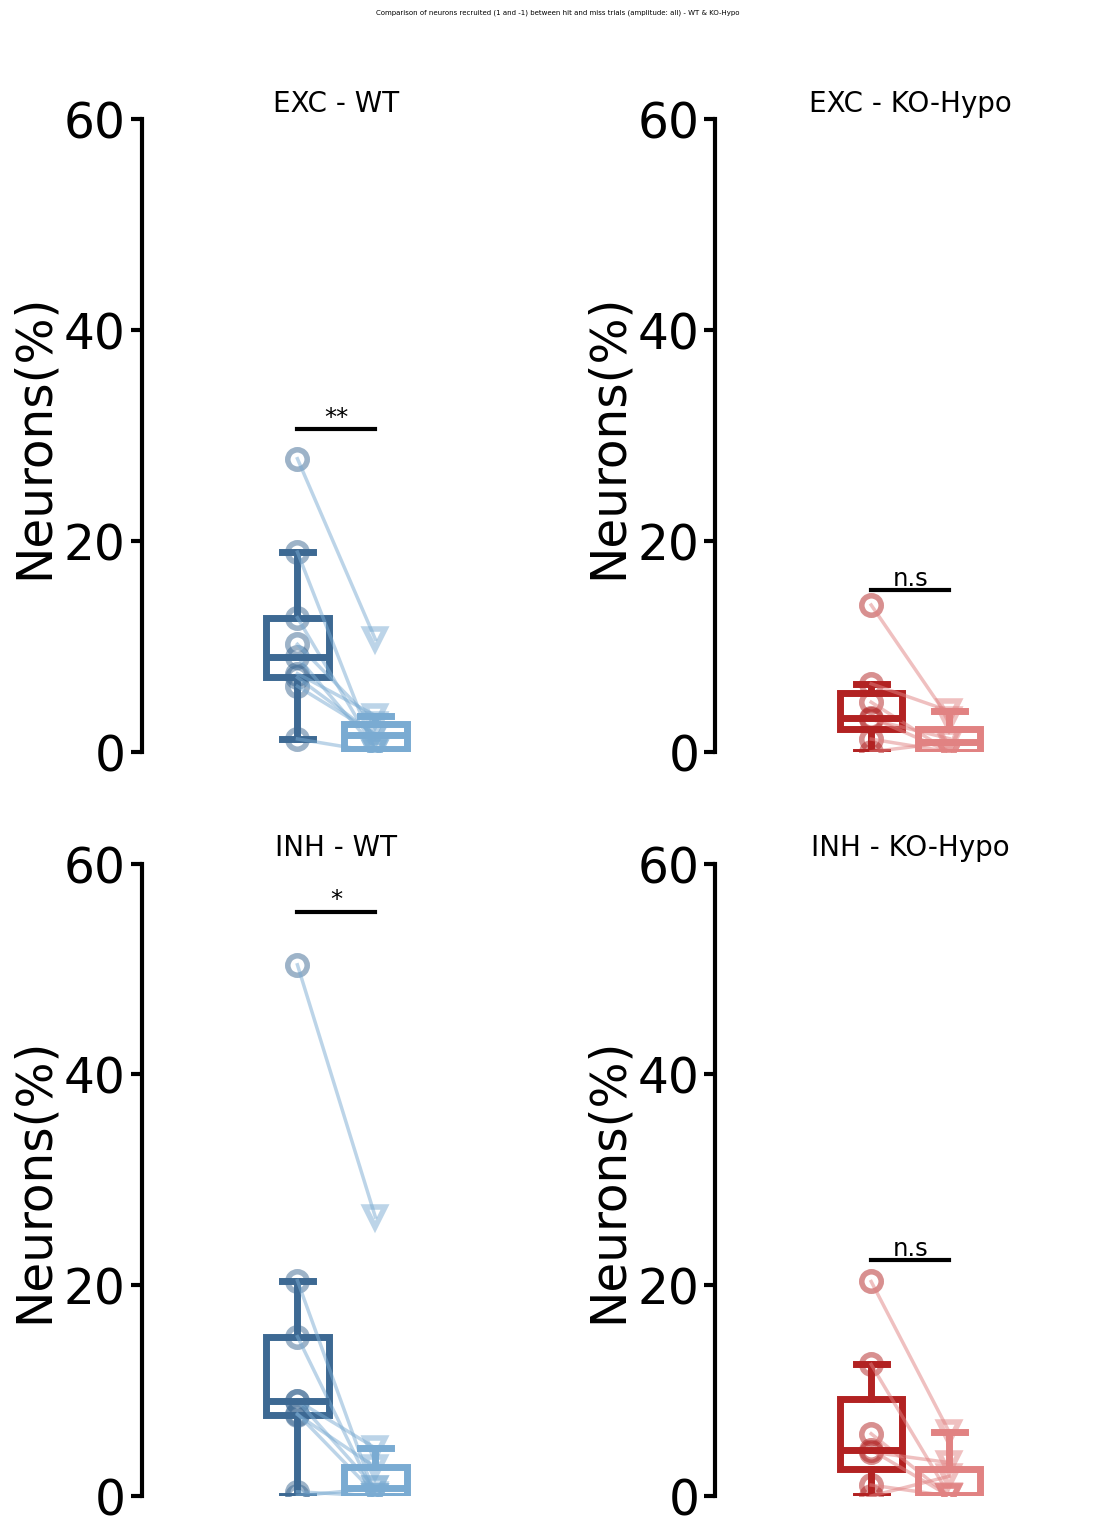

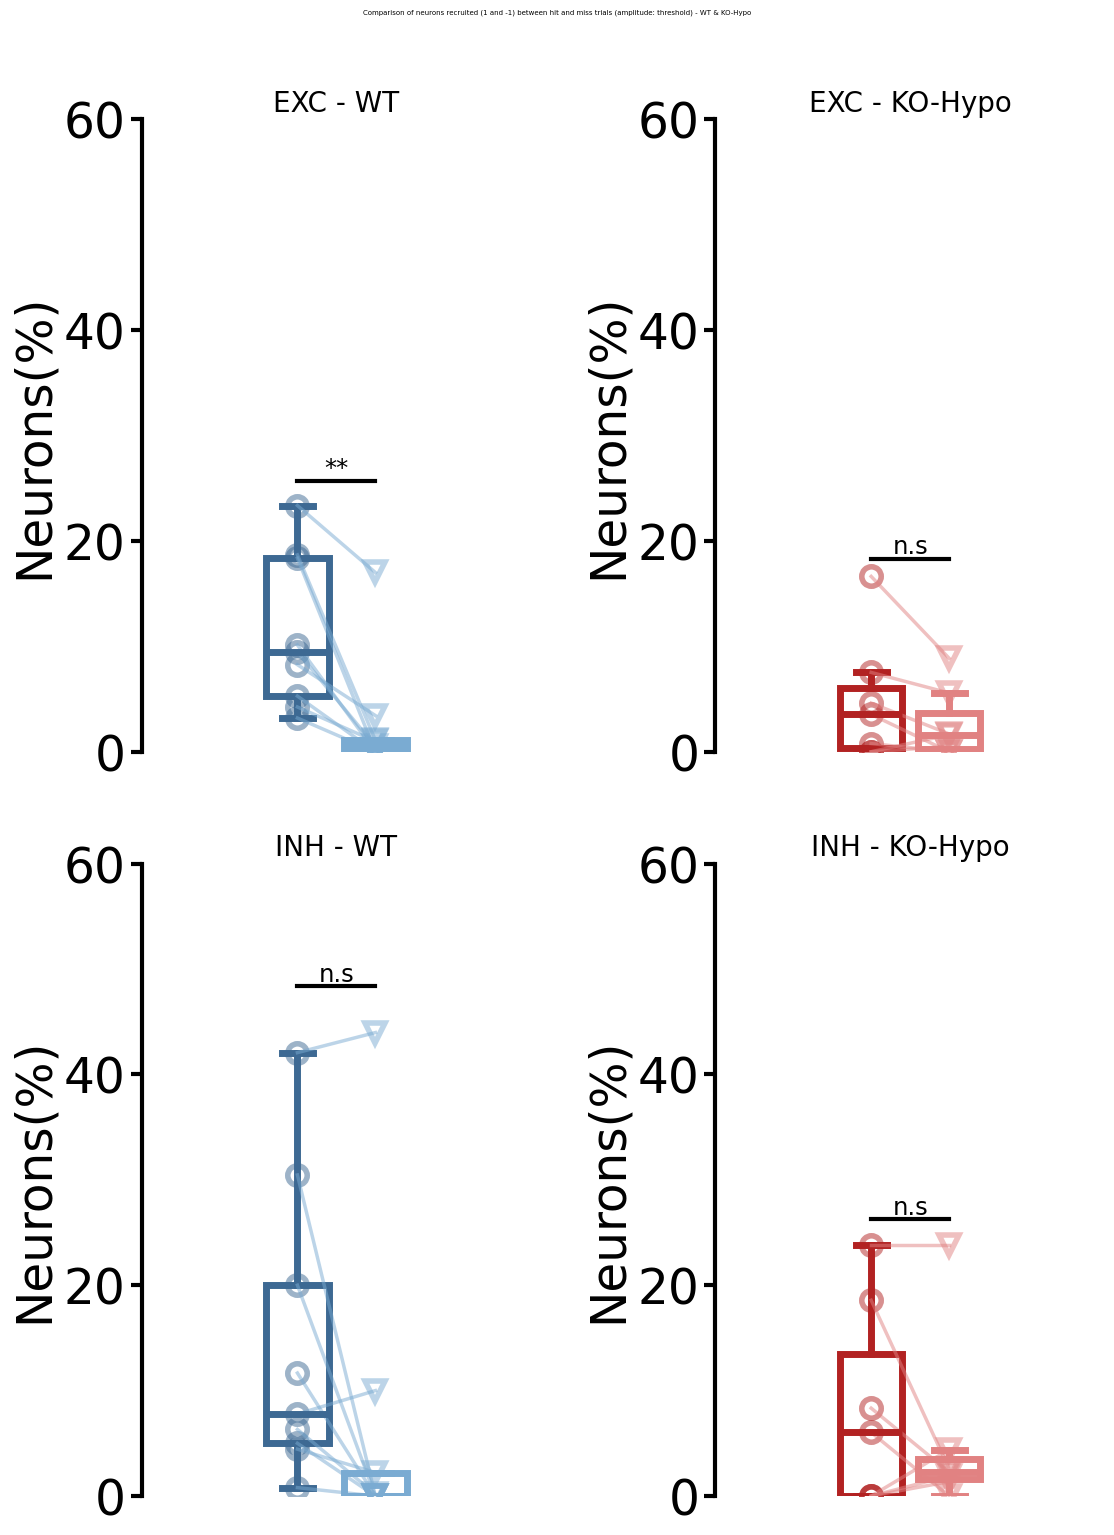

In [35]:
plot_neuron_frac_det_undet(0, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(0, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)

## Fraction of neurons activated(1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9715886255071312, pvalue=0.9079640372756269)
ShapiroResult(statistic=0.863747723217491, pvalue=0.10529506103779052)
TtestResult(statistic=3.816432083583067, pvalue=0.0051156101119442425, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7312187702483861, pvalue=0.008043278218586483)
ShapiroResult(statistic=0.810150556870984, pvalue=0.051542279826455324)
WilcoxonResult(statistic=1.0, pvalue=0.03125)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8397393690521138, pvalue=0.05737013972212317)
ShapiroResult(statistic=0.8345797836262635, pvalue=0.050251373298421366)
TtestResult(statistic=1.8230033642301497, pvalue=0.10576458349700633, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9679615092664401, pvalue=0.8833897122063161)
ShapiroResult(statistic=0.7350204561287395, pvalue=0.008826284312321865)
WilcoxonResult(statistic=0.0, pvalue=0.015625)
Boxplot plotting.
--- Neurons(

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


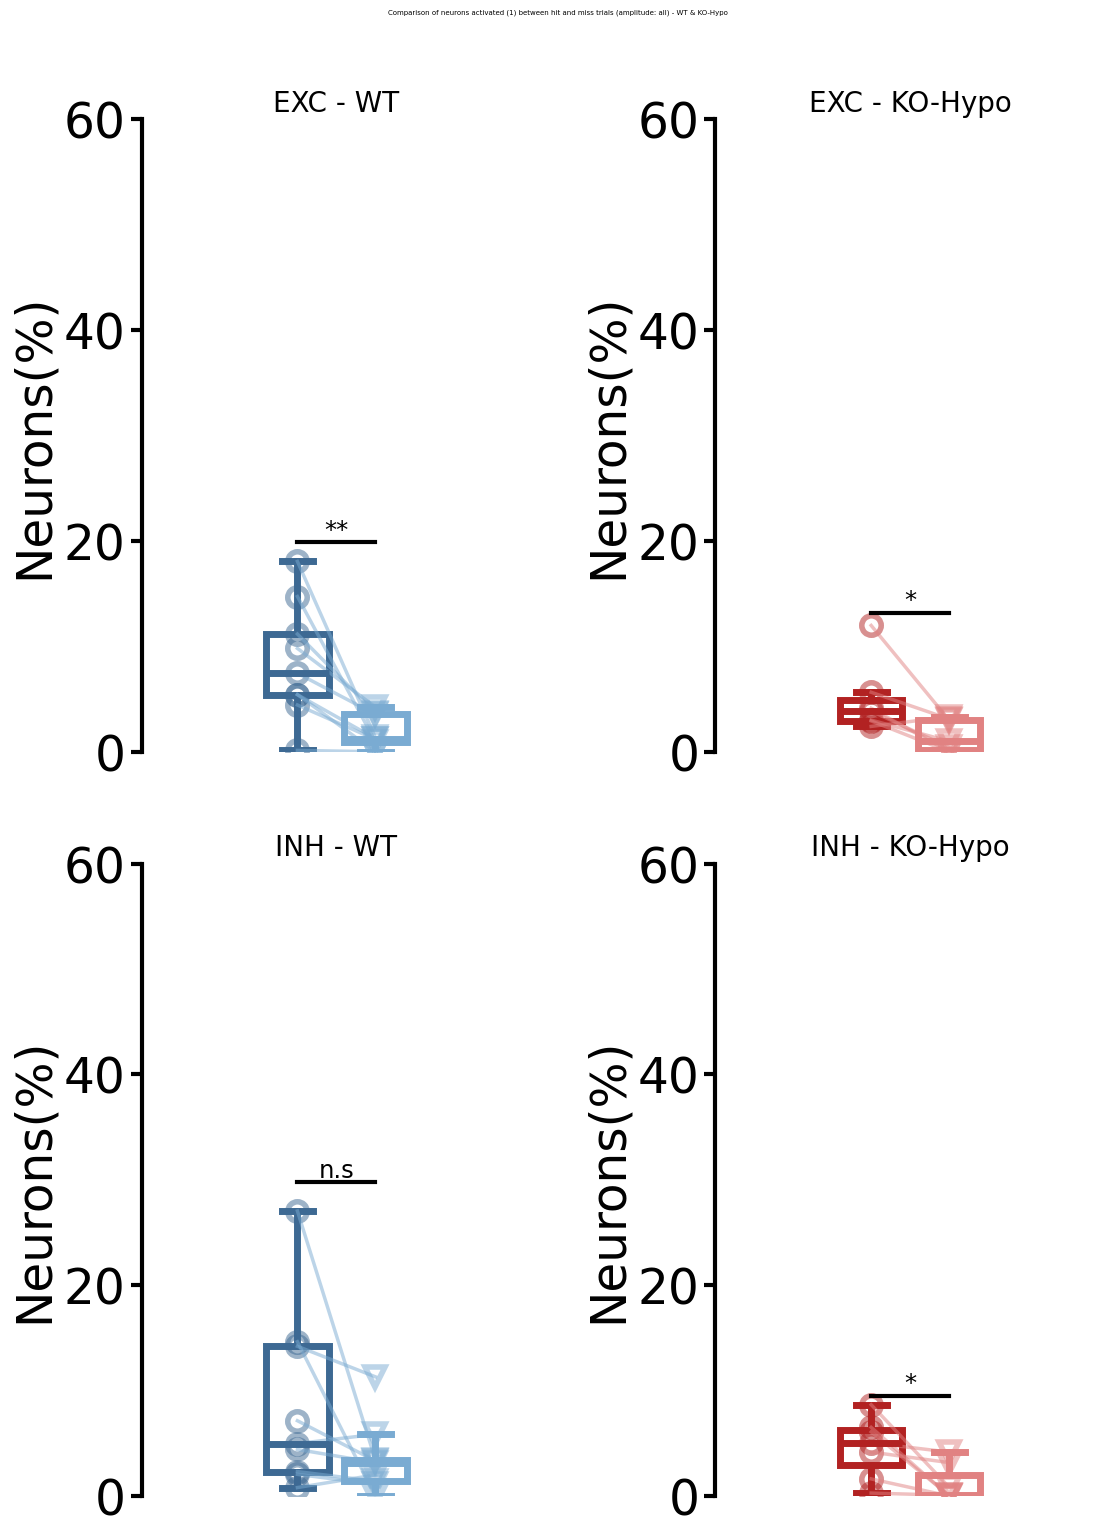

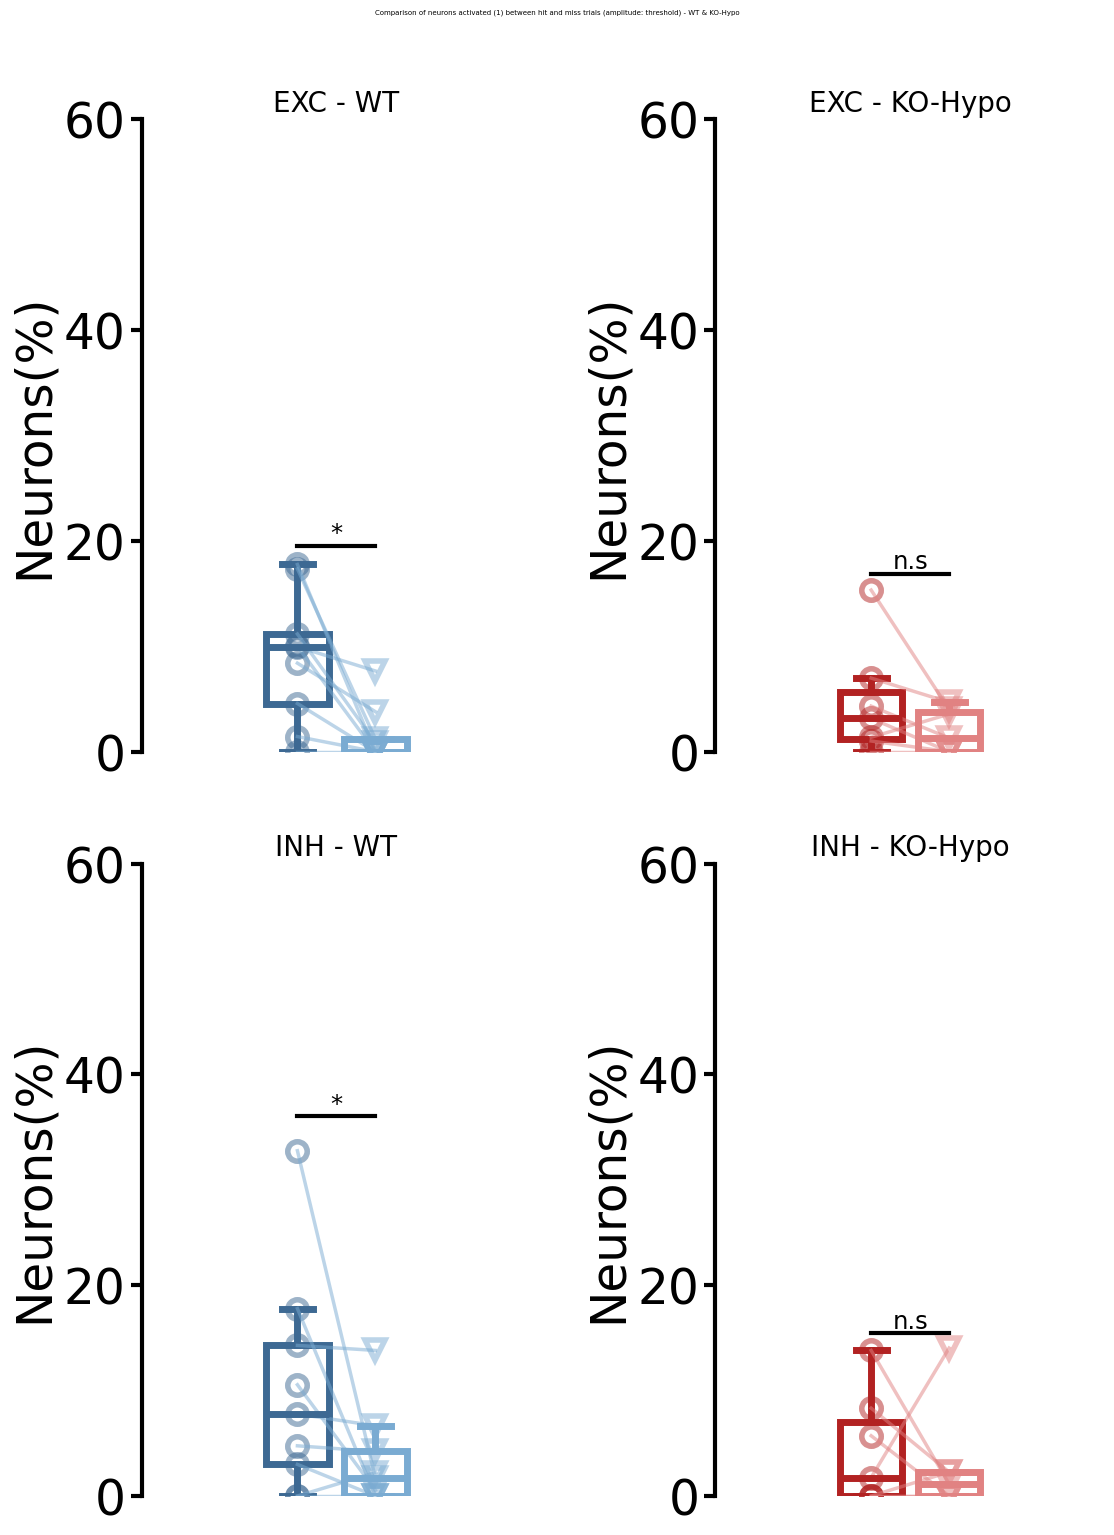

In [36]:
plot_neuron_frac_det_undet(1, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(1, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)

## Fraction of neurons inhibited (-1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5697065884454251, pvalue=4.218349212648518e-05)
ShapiroResult(statistic=0.47671476709066385, pvalue=3.4019071837248674e-06)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7549016184047022, pvalue=0.014271663635000379)
ShapiroResult(statistic=0.7941756942214614, pvalue=0.03585730503511788)
WilcoxonResult(statistic=2.0, pvalue=0.27332167829229814)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6033457785090619, pvalue=0.00010473030174722723)
ShapiroResult(statistic=0.4580979939042771, pvalue=2.053508891992133e-06)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5817495617994556, pvalue=0.00016557480473705546)
ShapiroResult(statistic=0.6135252153514845, pvalue=0.00039190819724697315)
WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6451458048832857, pvalue=0.0003237909880116198)
ShapiroResult(statistic=0.5379871097866749, pvalue=1.7883631548138785e-05)
WilcoxonResult(statistic=6.0, pvalue=0.17629637444051116)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8046759180421498, pvalue=0.04555376081405441)
ShapiroResult(statistic=0.7442778203651381, pvalue=0.011051946781549011)
WilcoxonResult(statistic=1.0, pvalue=0.07961580146011343)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6798300187894497, pvalue=0.0008247799532188891)
ShapiroResult(statistic=0.4677762997058612, pvalue=2.669814462162398e-06)
WilcoxonResult(statistic=9.0, pvalue=0.39802471950693785)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5739080192913607, pvalue=0.00013346803172028057)
ShapiroResult(statistic=0.8354009762068623, pvalue=0.08998393846573428)
WilcoxonResult(statistic=7.0, pvalue=0.892738400944348)


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


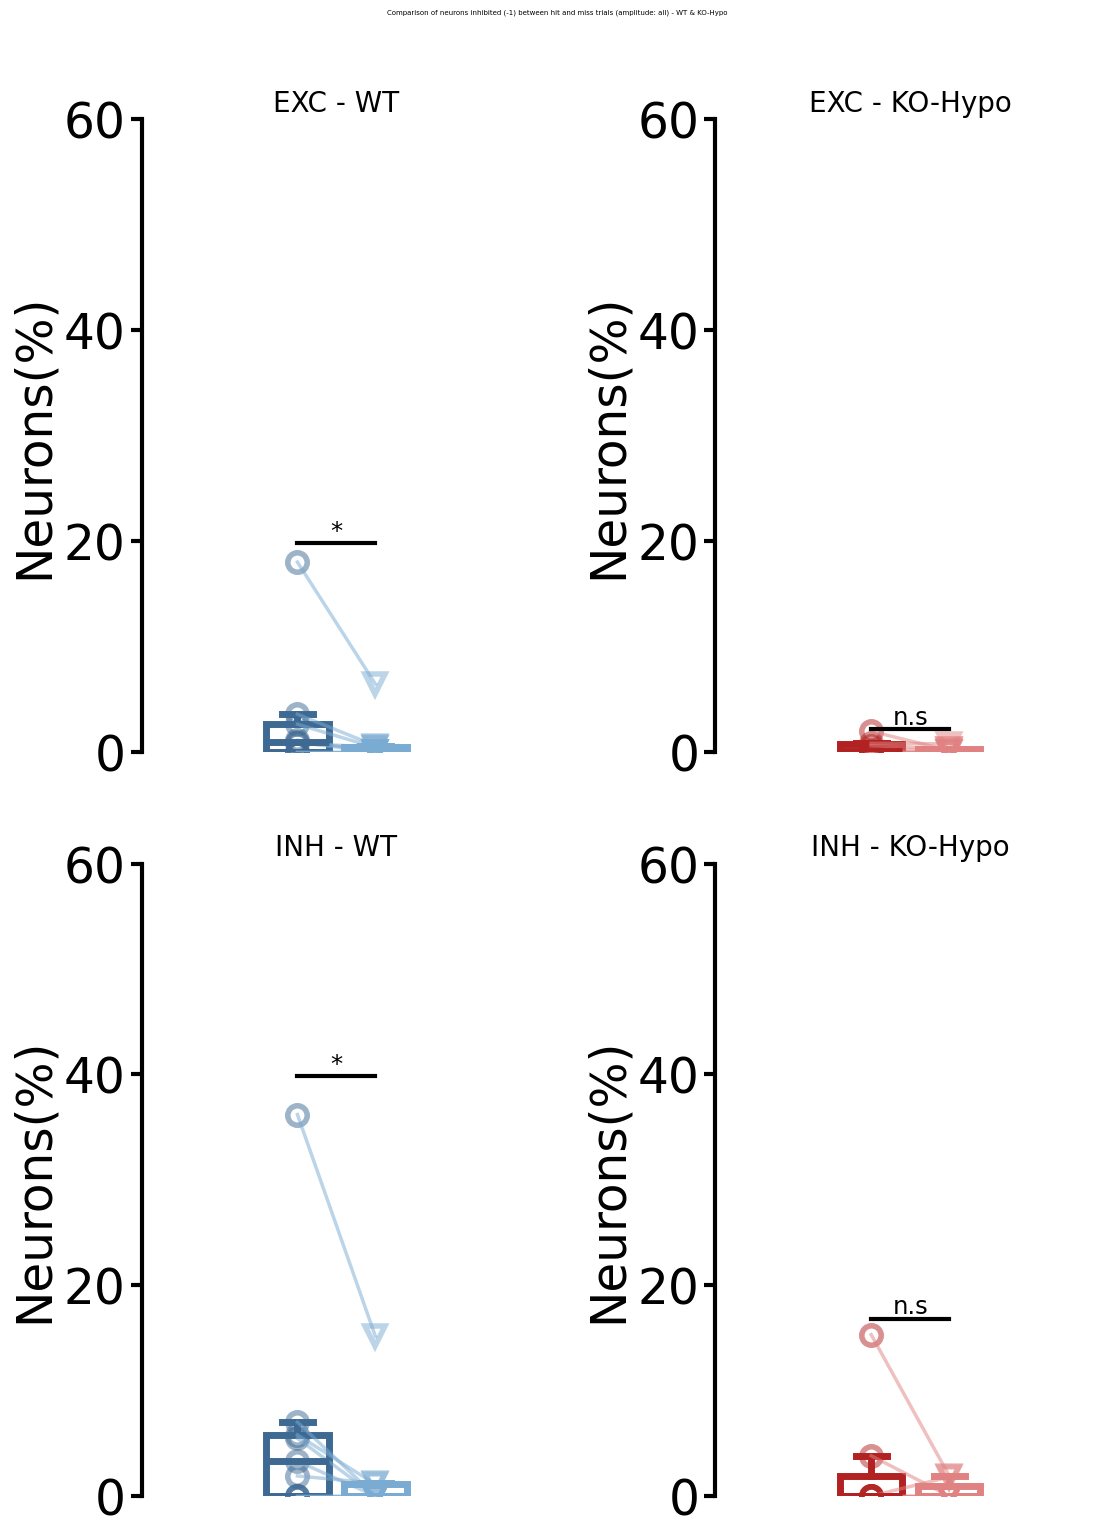

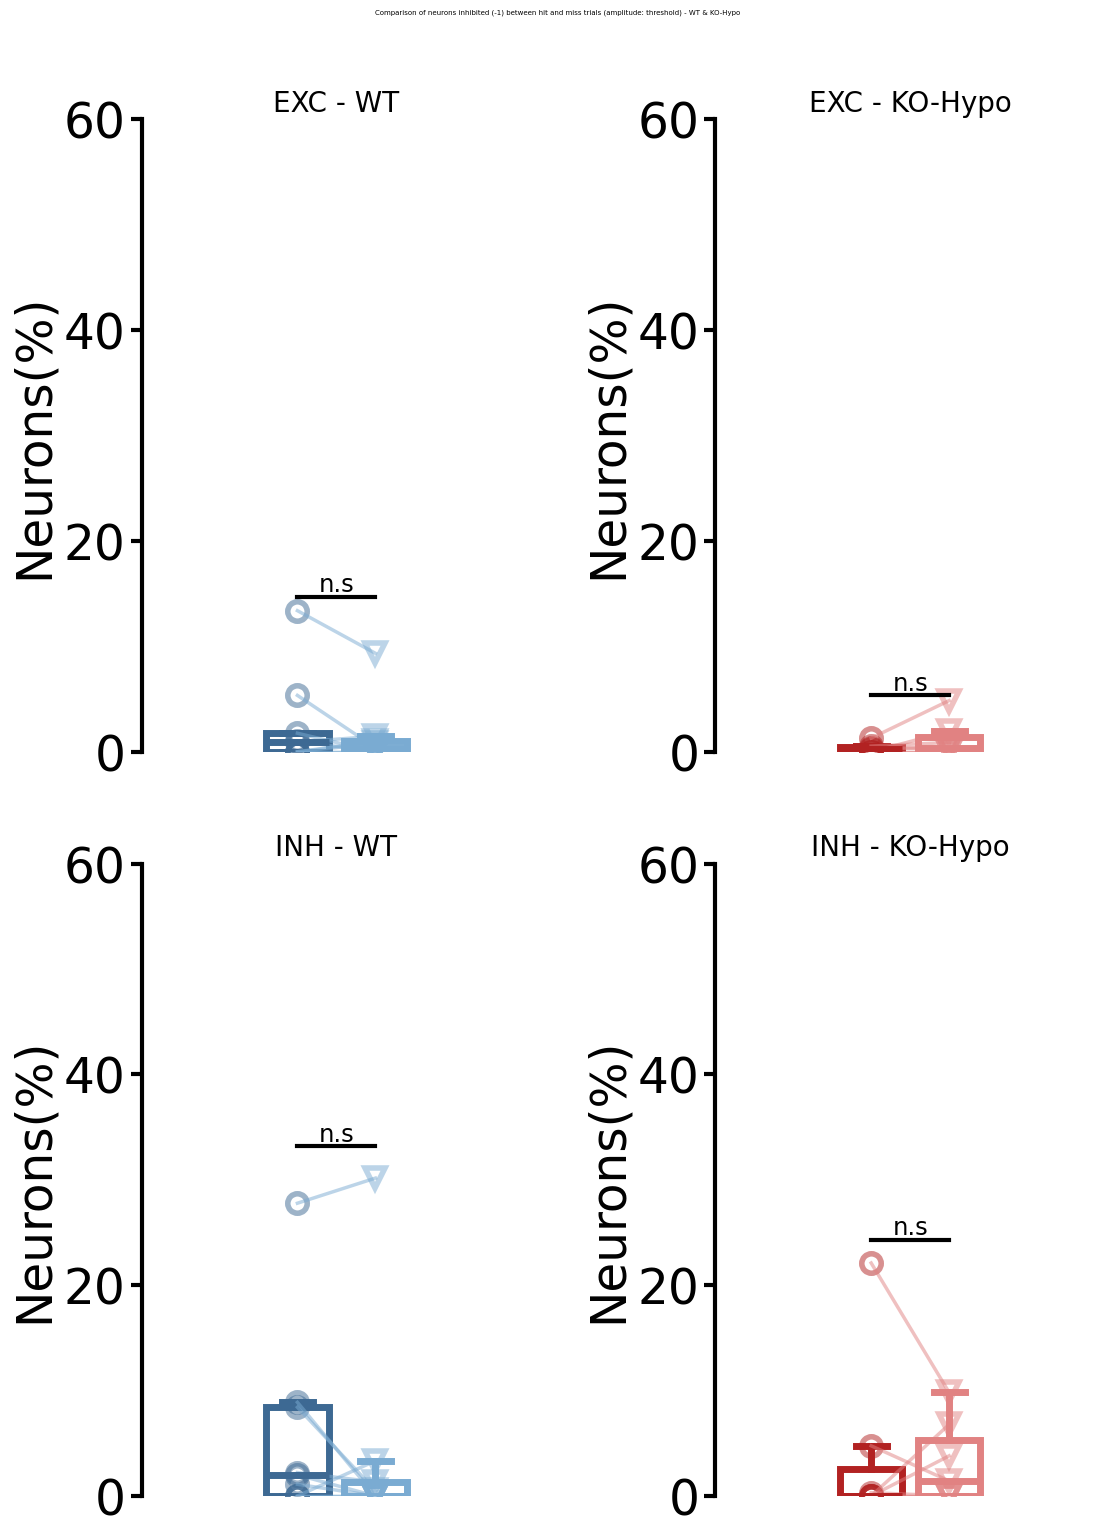

In [37]:
plot_neuron_frac_det_undet(-1, ko_hypo_only=True, stim_ampl="all", ylim=[0,60], no_go_normalize=True)
plot_neuron_frac_det_undet(-1, ko_hypo_only=True, stim_ampl="threshold", ylim=[0,60], no_go_normalize=True)

# Responsivity contrast between det and undet trials

## Ratio

### responsivity contrast of neurons recruited

In [38]:
def resp_contrast(pattern="recruited", stim_ampl="all", method="ratio", ylim=[]):
    pat_dict = {"recruited": 0, "activated": 1, "inhibited": -1}
    fig, axs = plt.subplots(1,2,figsize=(12,8))
    for i, type in enumerate(["EXC", "INH"]):
        wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pat_dict[pattern], n_type=type, ko_hypo_only=True, stim_ampl=stim_ampl)
        if method == "ratio":
            wt_nan = np.logical_and(wt_det>0, wt_undet>0)
            ko_nan = np.logical_and(ko_det>0, ko_undet>0)
            wt_det, ko_det, wt_undet, ko_undet = wt_det[wt_nan], ko_det[ko_nan], wt_undet[wt_nan], ko_undet[ko_nan]
            wt = wt_det/wt_undet
            ko = ko_det/ko_undet
        elif method == "delta":
            wt = wt_det - wt_undet
            ko = ko_det - ko_undet
        ppt.boxplot(axs[i], wt, ko, ylabel=f"{method} nb neuron Hit/Miss", paired=False, ylim=ylim)
        fig.suptitle(f"Comparaison of {method} of {pattern} neurons between detected and undetected trials for {stim_ampl} stimulus", fontsize=10)
    fig.tight_layout()
    if save_figure:
        fig.savefig(server_address + f"Figure2/responsivity/contrast_resp_{method}({pattern})_{stim_ampl}.pdf")
    plt.show()

Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6832133463623002, pvalue=0.0024243009731878588)
ShapiroResult(statistic=0.9383418303450735, pvalue=0.5207477817506674)
MannwhitneyuResult(statistic=16.0, pvalue=0.26666666666666666)
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7072640927970681, pvalue=0.011389991835216847)
ShapiroResult(statistic=0.7646482453014997, pvalue=0.03263223079014688)
MannwhitneyuResult(statistic=7.0, pvalue=1.0)


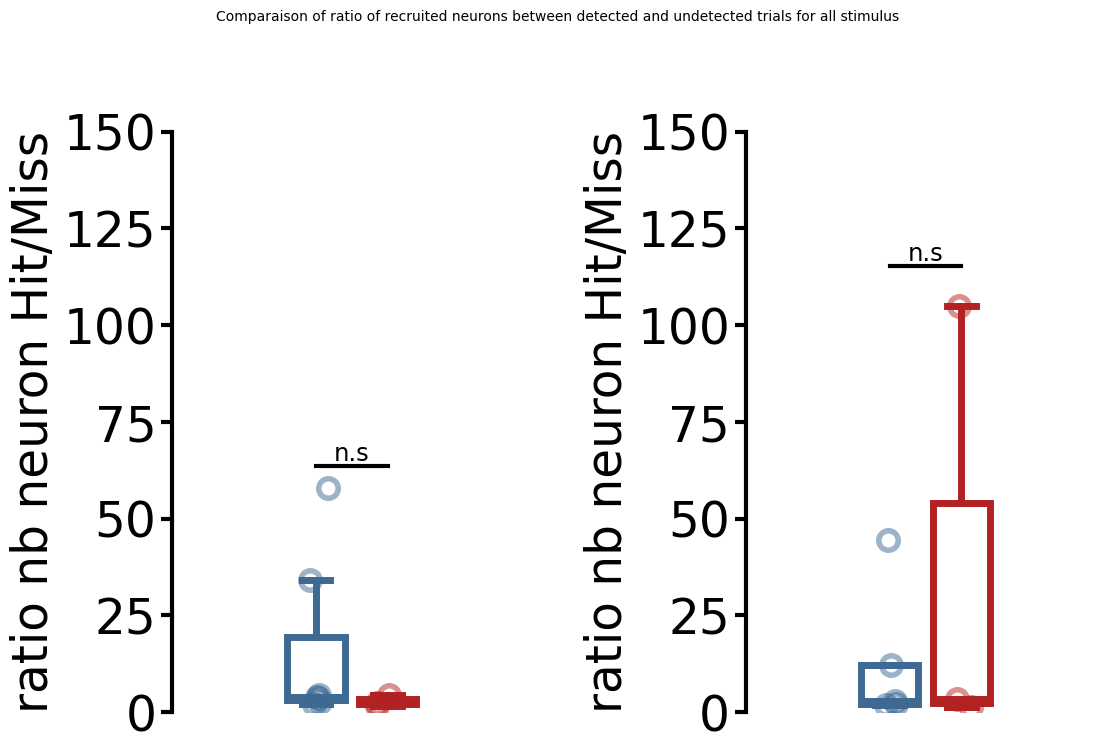

Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7932793447040014, pvalue=0.07135210466817479)
ShapiroResult(statistic=0.9809502233502851, pvalue=0.7355552653213737)
LeveneResult(statistic=2.27870023247326, pvalue=0.18190051898421378)
Equal variances :TtestResult(statistic=1.3576000209199075, pvalue=0.2234279420848881, df=6.0)
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6554927779498751, pvalue=0.00308335169140427)
ShapiroResult(statistic=0.9932432432432429, pvalue=0.842833201535055)
MannwhitneyuResult(statistic=4.0, pvalue=0.6285714285714286)


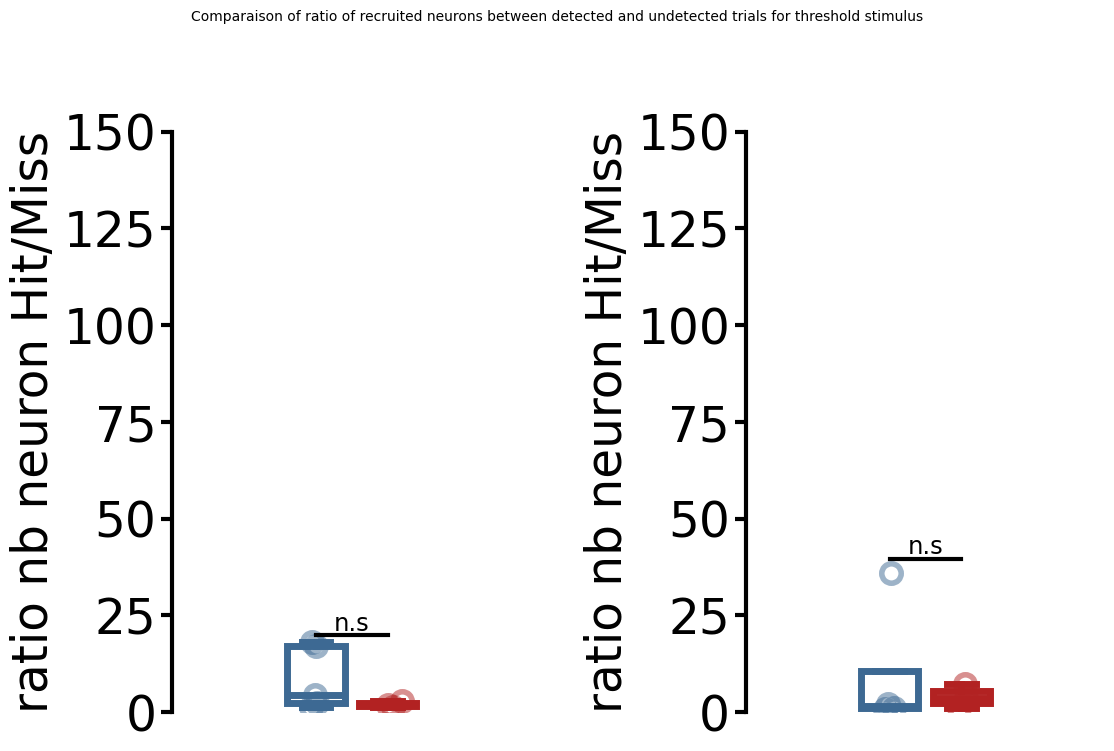

In [39]:
resp_contrast(pattern="recruited", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="recruited", stim_ampl="threshold", method="ratio", ylim=[0, 150])

### responsivity contrast of neurons activated

Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7490969648804104, pvalue=0.012414991854708965)
ShapiroResult(statistic=0.8699771773950621, pvalue=0.26633136916155864)
MannwhitneyuResult(statistic=24.0, pvalue=0.3434343434343435)
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.650939110080778, pvalue=0.0006203938593620532)
ShapiroResult(statistic=0.6074724415840522, pvalue=0.0007870100190918089)
MannwhitneyuResult(statistic=12.0, pvalue=0.28438228438228436)


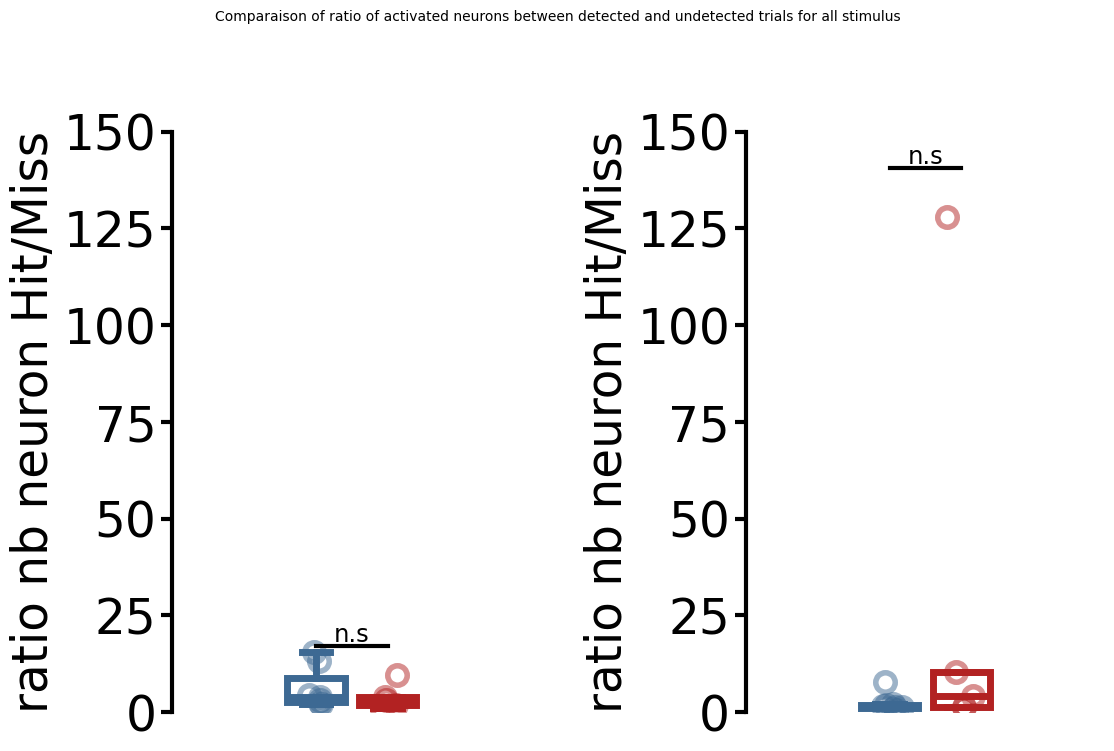

Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.806073968564818, pvalue=0.11356657530486602)
ShapiroResult(statistic=0.9249634777444847, pvalue=0.5651232318568179)
LeveneResult(statistic=120.73878164495375, pvalue=3.3762924936750623e-05)
Unequal variances: TtestResult(statistic=1.5360587096314062, pvalue=0.17543134096730928, df=6.0)
Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6878503146474997, pvalue=0.007116297158227072)
ShapiroResult(statistic=0.9475106980168405, pvalue=0.5585196364085203)
MannwhitneyuResult(statistic=9.0, pvalue=0.7642282177641773)


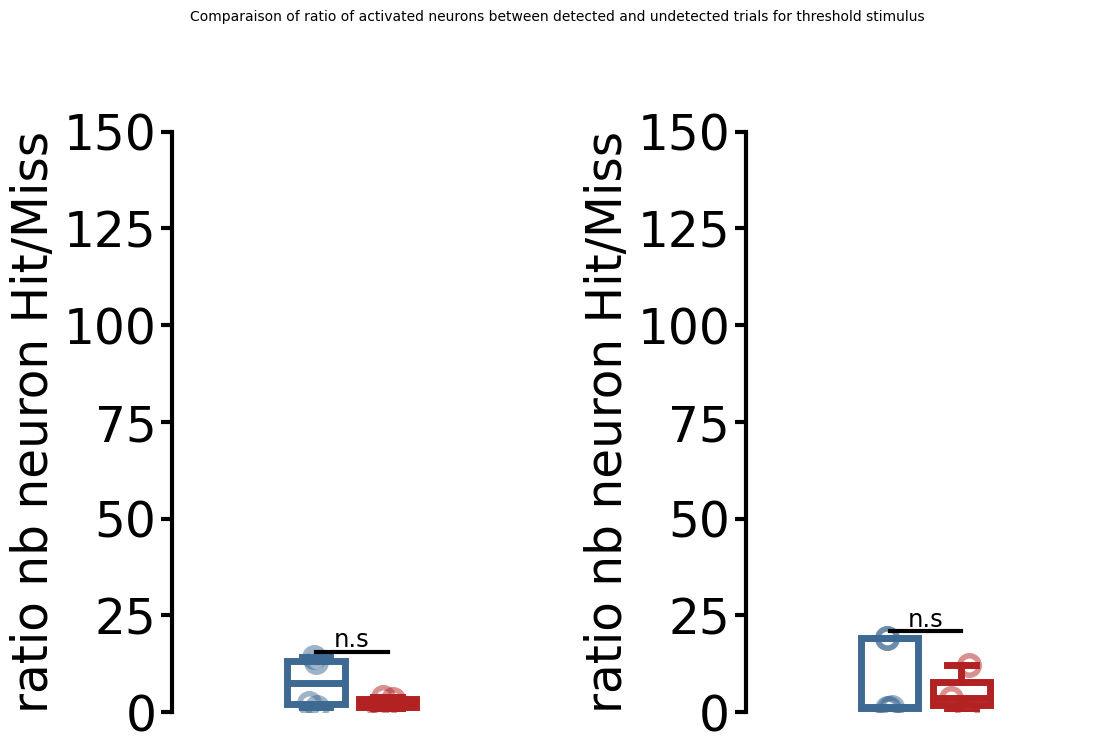

In [40]:
resp_contrast(pattern="activated", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="activated", stim_ampl="threshold", method="ratio", ylim=[0, 150])

### responsivity contrast of neurons inhibited


Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.8543666960282026, pvalue=0.24061821928502636)
ShapiroResult(statistic=0.7189331955579275, pvalue=0.018882298949208672)
MannwhitneyuResult(statistic=11.0, pvalue=0.4857142857142857)
Boxplot plotting.


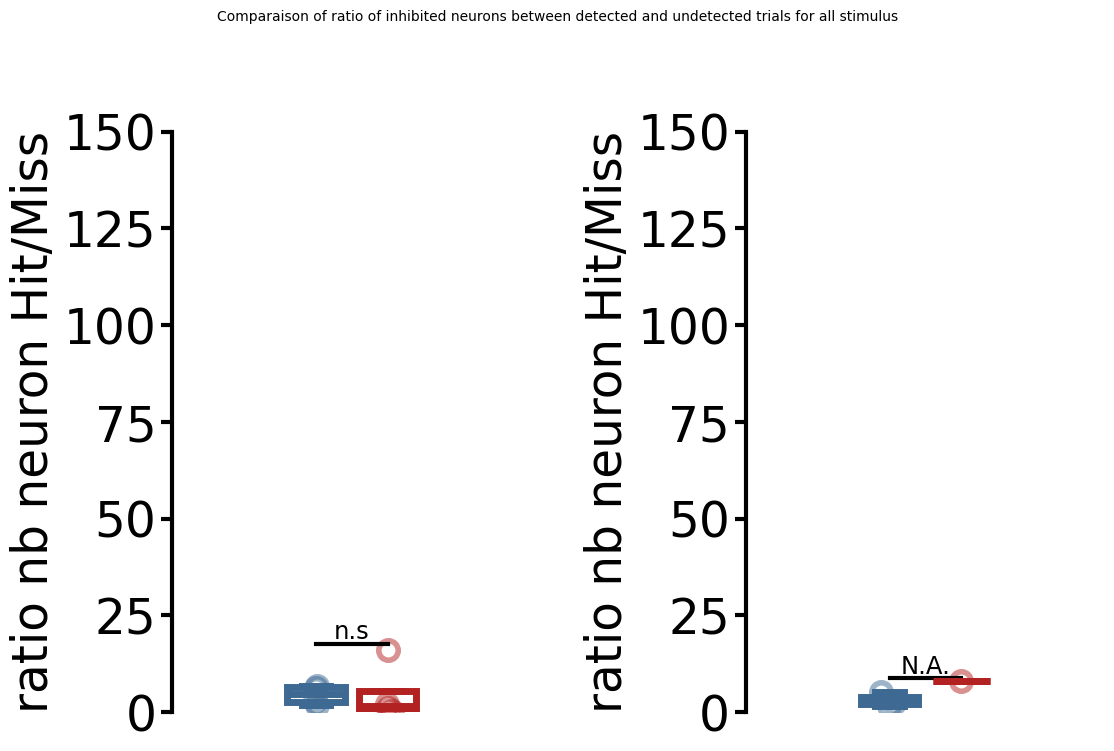

Boxplot plotting.
--- ratio nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7968470925590349, pvalue=0.10699332327260214)
ShapiroResult(statistic=0.9929501533750239, pvalue=0.9720583169845579)
LeveneResult(statistic=1.5432508078341516, pvalue=0.26922116627051434)
Equal variances :TtestResult(statistic=1.2913801606405564, pvalue=0.2530464819015456, df=5.0)
Boxplot plotting.


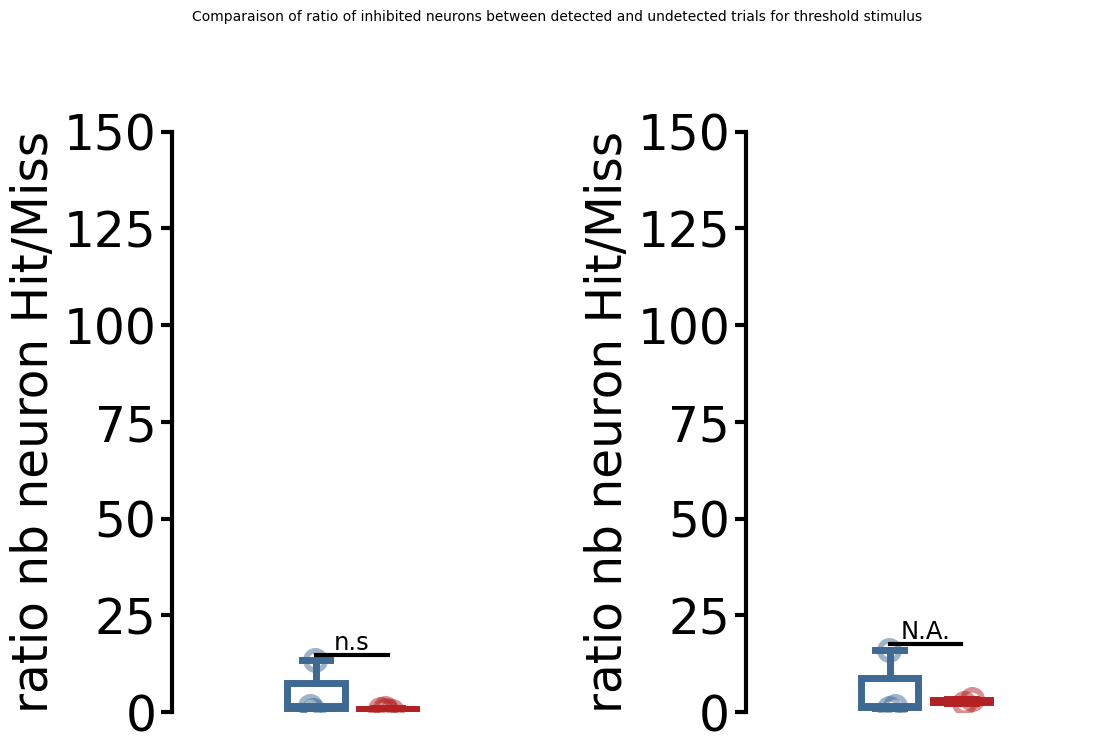

In [41]:
resp_contrast(pattern="inhibited", stim_ampl="all", method="ratio", ylim=[0, 150])
resp_contrast(pattern="inhibited", stim_ampl="threshold", method="ratio", ylim=[0, 150])

## Delta

### Recruited

Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.9249148410418963, pvalue=0.4344757011227893)
ShapiroResult(statistic=0.8813680019549699, pvalue=0.23259001381394728)
LeveneResult(statistic=1.7808543881293342, pvalue=0.203343978932881)
Equal variances :TtestResult(statistic=2.1101727084196162, pvalue=0.05331945048052623, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.9199809050281498, pvalue=0.392081628447534)
ShapiroResult(statistic=0.9163398815904255, pvalue=0.44150468825217914)
LeveneResult(statistic=0.620048795296103, pvalue=0.4441566259549097)
Equal variances :TtestResult(statistic=1.0653452602423588, pvalue=0.30474895594653173, df=14.0)


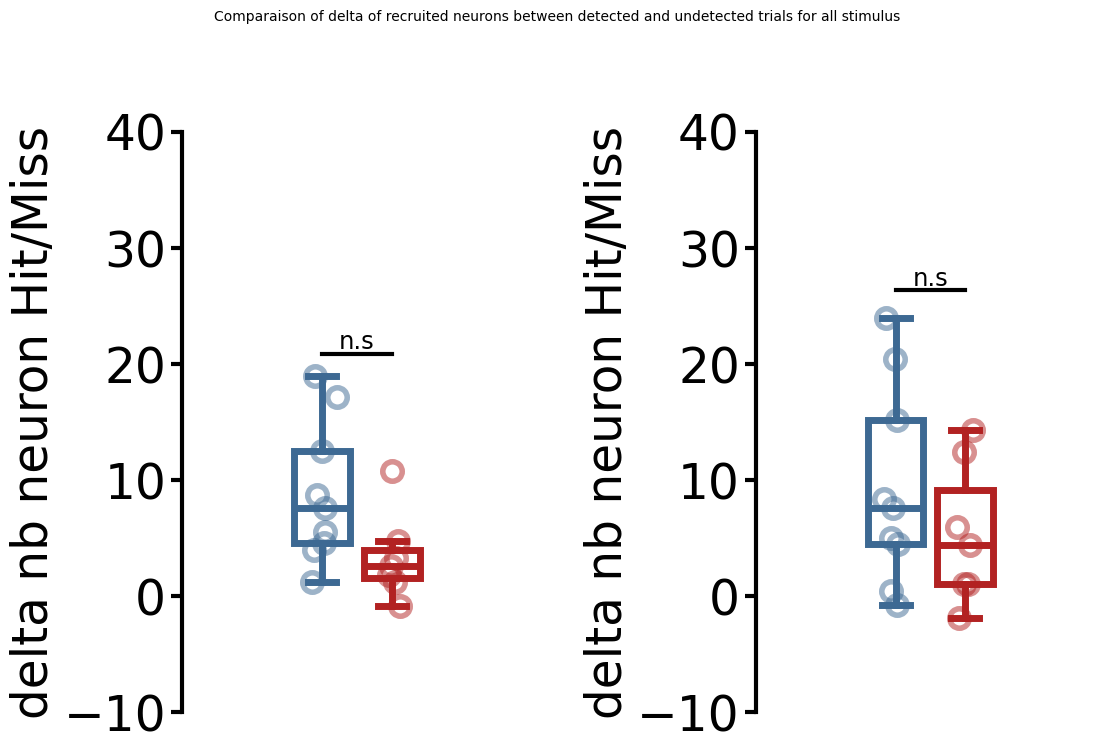

Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.8411815788317778, pvalue=0.059528041760937705)
ShapiroResult(statistic=0.9503064474840932, pvalue=0.7324884509244843)
LeveneResult(statistic=1.3357225780340822, pvalue=0.2671332644696904)
Equal variances :TtestResult(statistic=2.6994313652752173, pvalue=0.01727587707839676, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.8661340057019269, pvalue=0.1117335888596912)
ShapiroResult(statistic=0.8882097871618677, pvalue=0.26545480711597264)
LeveneResult(statistic=0.5471928686840226, pvalue=0.47168979554927615)
Equal variances :TtestResult(statistic=1.0682008309049615, pvalue=0.3035034958927587, df=14.0)


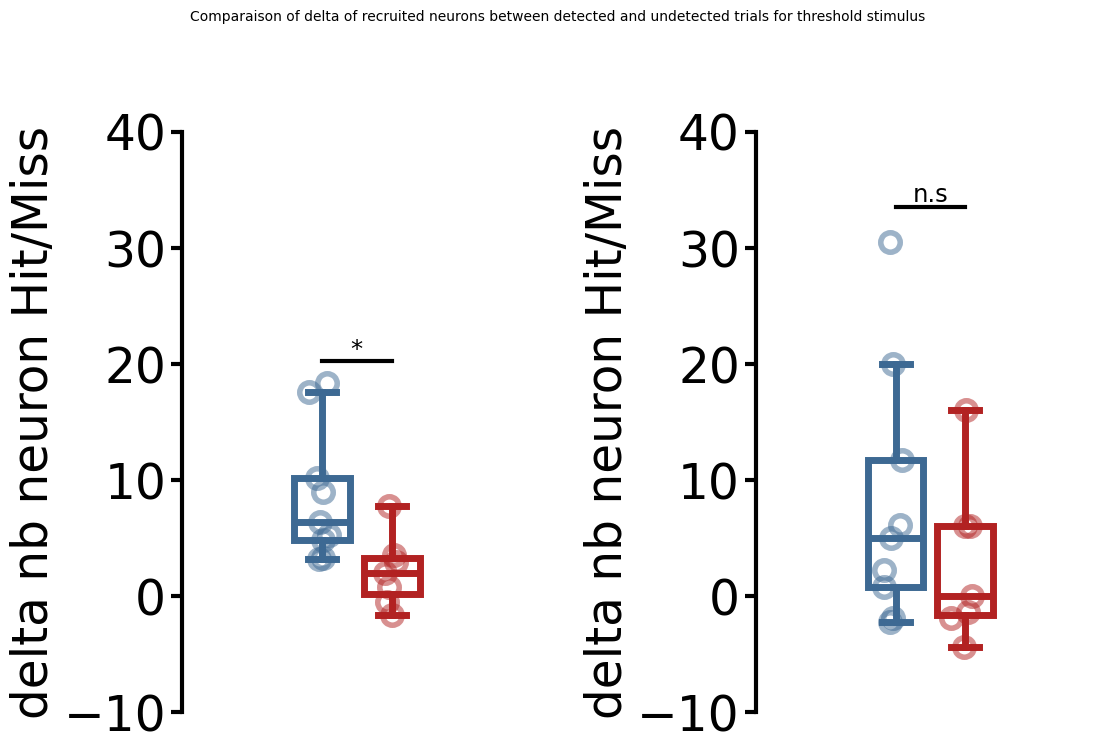

In [45]:
resp_contrast(pattern="recruited", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="recruited", stim_ampl="threshold", method="delta", ylim=[-10, 40])

### Activated

Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.8808171321342722, pvalue=0.16015654141207258)
ShapiroResult(statistic=0.9061906196640928, pvalue=0.3701275919633306)
LeveneResult(statistic=1.0552147112810948, pvalue=0.32173116667374896)
Equal variances :TtestResult(statistic=1.5250575494697396, pvalue=0.1495135959432007, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7360369834989959, pvalue=0.0037325767131132525)
ShapiroResult(statistic=0.8322454575241348, pvalue=0.08403101869946968)
MannwhitneyuResult(statistic=29.0, pvalue=0.8370629370629371)


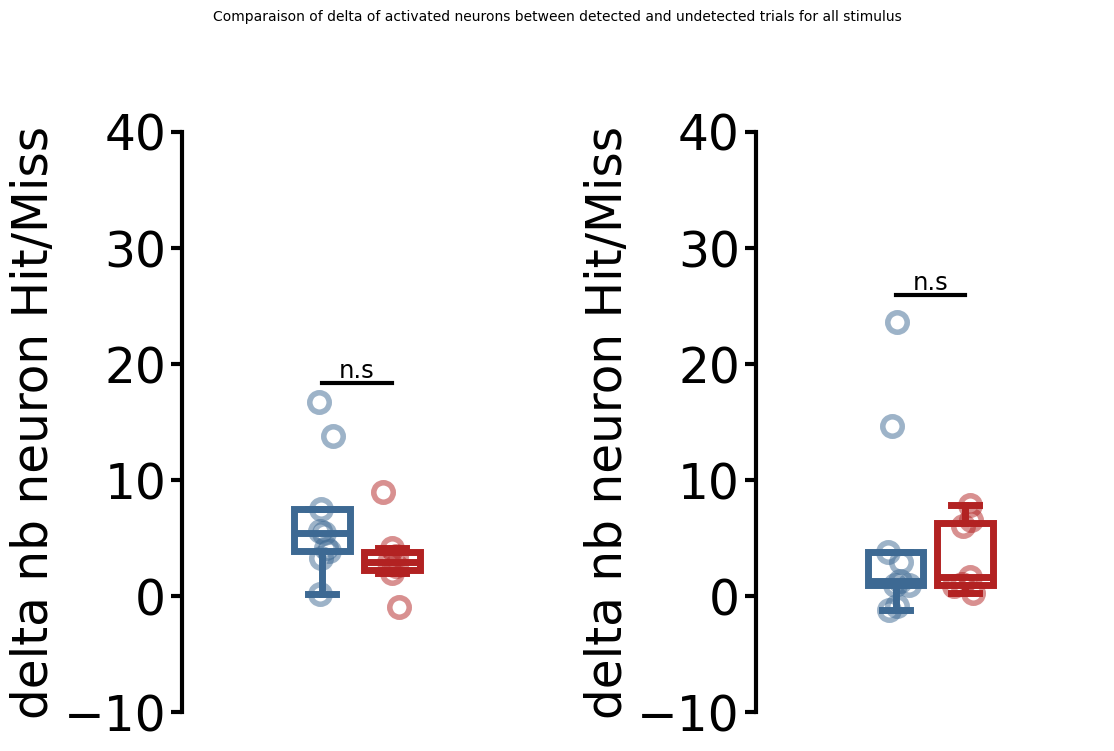

Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.9071202076470317, pvalue=0.2962359259201553)
ShapiroResult(statistic=0.8579701542496766, pvalue=0.1451690209795018)
LeveneResult(statistic=1.4075601629580126, pvalue=0.25520583398238444)
Equal variances :TtestResult(statistic=1.6980726649955233, pvalue=0.11159983493502804, df=14.0)
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7761851222919105, pvalue=0.010885632540609019)
ShapiroResult(statistic=0.9582610449158586, pvalue=0.8036841789609119)
MannwhitneyuResult(statistic=41.0, pvalue=0.3393373450023185)


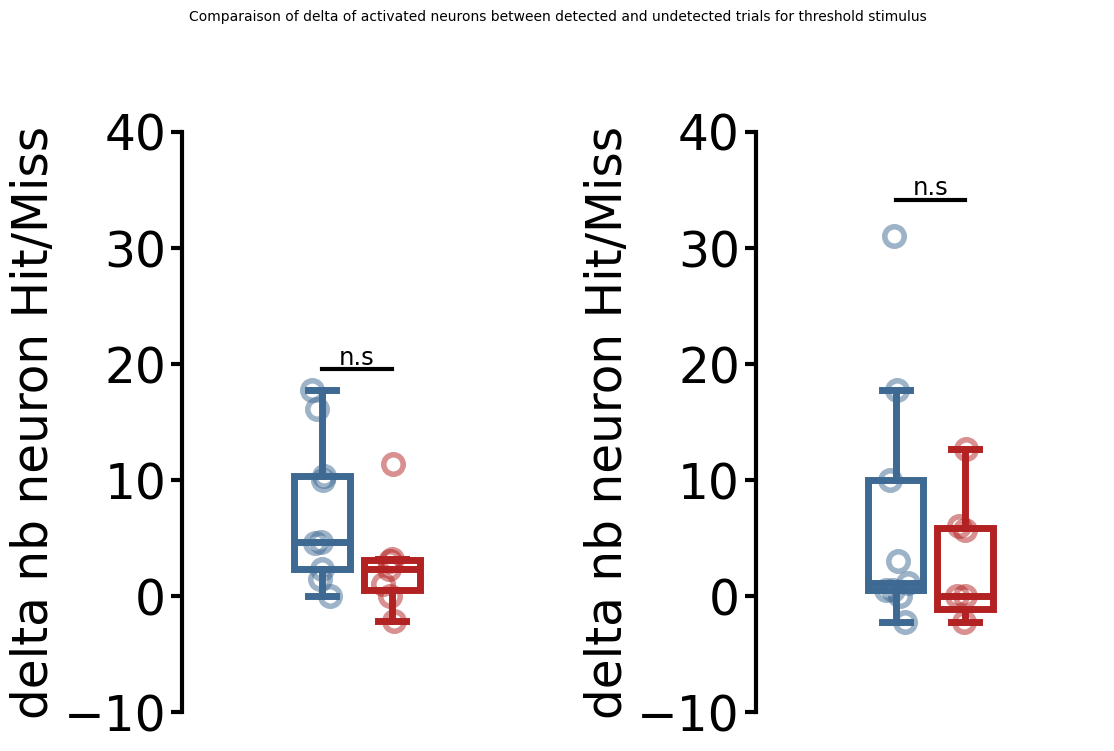

In [46]:
resp_contrast(pattern="activated", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="activated", stim_ampl="threshold", method="delta", ylim=[-10, 40])

### Inhibited

Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.6291149456667684, pvalue=0.00021006523501600533)
ShapiroResult(statistic=0.6336258226072227, pvalue=0.0006692747889564687)
MannwhitneyuResult(statistic=46.5, pvalue=0.11504062663497347)
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.7277972486944733, pvalue=0.0029933730823843564)
ShapiroResult(statistic=0.691751763193047, pvalue=0.003011105838063292)
MannwhitneyuResult(statistic=44.0, pvalue=0.18484397422753407)


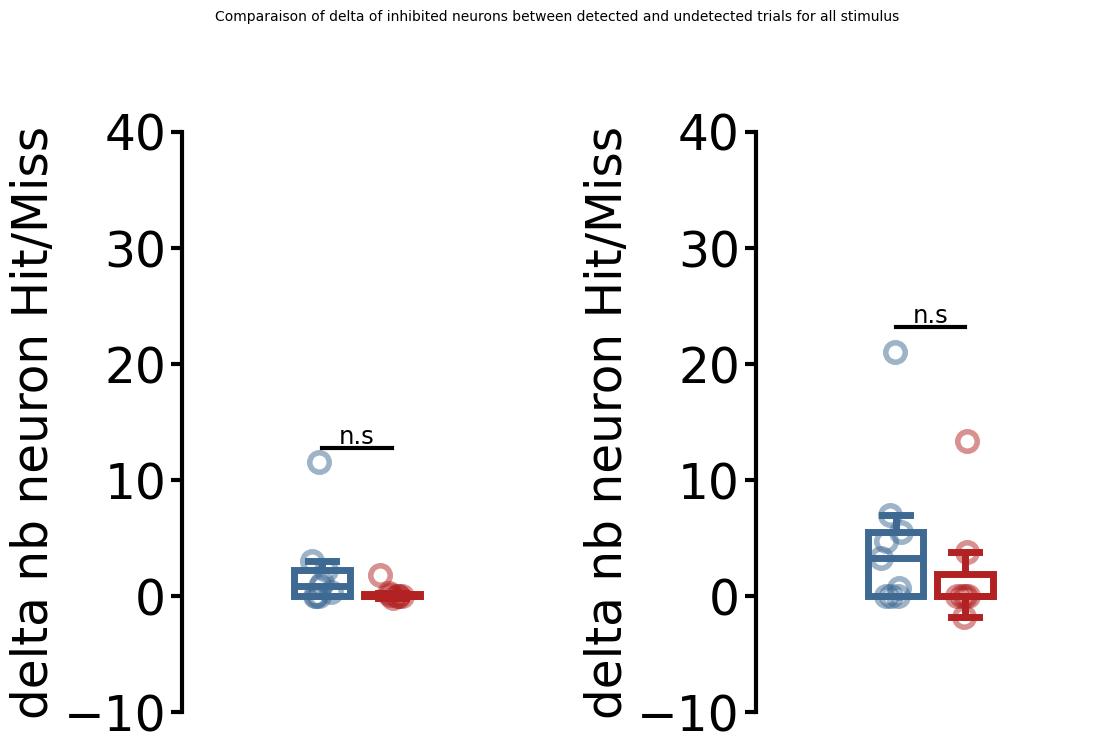

Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.8528144529950296, pvalue=0.08002427644047021)
ShapiroResult(statistic=0.7142286689820816, pvalue=0.0052902134575126235)
MannwhitneyuResult(statistic=44.0, pvalue=0.20066515929601692)
Boxplot plotting.
--- delta nb neuron Hit/Miss ---
ShapiroResult(statistic=0.875661548478173, pvalue=0.14129166204188454)
ShapiroResult(statistic=0.9084743186834221, pvalue=0.38541067241599897)
LeveneResult(statistic=0.25370947049490566, pvalue=0.6223077994287043)
Equal variances :TtestResult(statistic=0.3581761358652702, pvalue=0.7255545278009501, df=14.0)


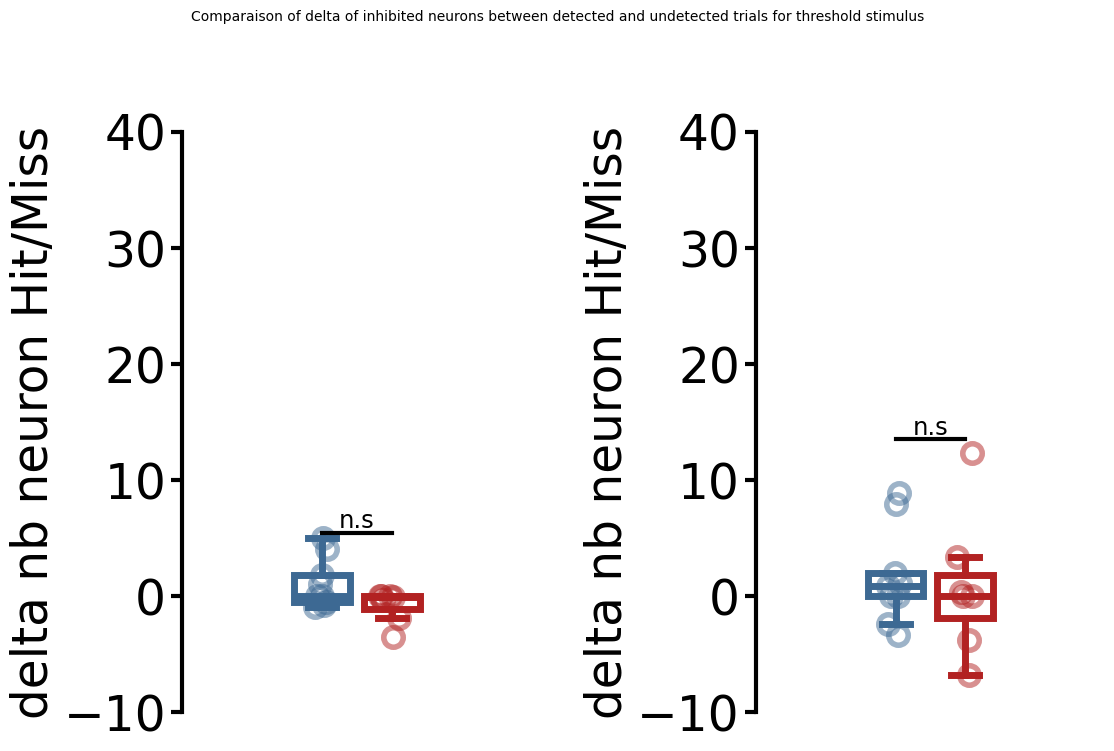

In [47]:
resp_contrast(pattern="inhibited", stim_ampl="all", method="delta", ylim=[-10, 40])
resp_contrast(pattern="inhibited", stim_ampl="threshold", method="delta", ylim=[-10, 40])

# Responsivity per amplitude line graphs 22/03/2024

## Graph of activated neurons from amplitude

In [50]:
def plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=True, ylim=[], signif=False, sign_exc_inh=[[], []]):
    pat_dict = {"recruited": 0, "activated": 1, "inhibited": -1}
    assert detected_trials or undetected_trials
    genotype_dict = {"WT": 0, "KO": 1, "KO-Hypo": 2}
    anova_arr = np.empty((0, 4))
    fig, axs = plt.subplots(2, 1, figsize=(12, 16))
    labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
    amps = np.arange(2, 14, 2)
    
    for i, n_type in enumerate(["EXC","INH"]):
        wt, ko, ko_hypo = [], [], []
        for rec in recs.values():
            resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
            resp_p = []
            # The no-go trials are used to normalized
            trials_no_go = resp_mat[:, rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)]
            # The total number of neurons is computed
            total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
            
            trials_no_go[trials_no_go != 1] = 0
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go,axis=0))
            # For each amplitude, the number of activated neurons is computed
            for amp in amps:
                if detected_trials and undetected_trials:
                    stim_filter = rec.stim_ampl == amp
                elif detected_trials:
                    stim_filter = np.logical_and(rec.detected_stim, rec.stim_ampl == amp)
                elif undetected_trials:
                    stim_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl == amp)
                    
                trials = resp_mat[:, stim_filter]
                if pattern != "recruited":
                    trials[trials != pat_dict[pattern]] = 0
                recruited_det = np.mean(np.count_nonzero(trials, axis=0))
                # recruited_det -= recruited_no_go
                # recruited_det = 0 if recruited_det < 0 else recruited_det
                
                perc_n_det = (recruited_det/total_n)*100
                anova_arr = np.row_stack((anova_arr, np.array([genotype_dict[rec.genotype], perc_n_det, amp, rec.filename])))
                anova_df = pd.DataFrame(anova_arr, columns=["Genotype", "Neurons", "Amplitude", "ID"], dtype=float)
                if np.isfinite(perc_n_det):
                    resp_p.append(perc_n_det)
                else: 
                    resp_p.append(0)
                    
            if rec.genotype == "WT":
                wt.append(resp_p)
            elif rec.genotype =="KO-Hypo":
                ko_hypo.append(resp_p)
            elif rec.genotype =="KO":
                ko.append(resp_p)
        
        axs[i].errorbar(amps,np.nanmean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko,axis=0),linestyle="-.", color="#c57c9a",yerr=ss.sem(ko,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(ko_hypo,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].grid(False)
        axs[i].set_facecolor("white")
        axs[i].spines["left"].set_color("black")
        axs[i].spines["bottom"].set_color("black")
        axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True, bottom=True)
        axs[i].set_ylabel("Neurons (%)")
        axs[i].set_xlabel("Stimulus amplitude")
        axs[i].set_xlim([0, 14])
        if ylim:
            axs[i].set_ylim(ylim)
        axs[i].set_title(labels[n_type])
        axs[i].tick_params(axis='both')
        axs[i].set_xticks(amps)
        axs[i].spines[['right', 'top',]].set_visible(False)
        axs[0].get_xaxis().set_visible(False)
        
        if signif:
            # print(ss.shapiro(wt, axis=1).pvalue)
            # print(ss.shapiro(ko).pvalue)
            # print(ss.shapiro(ko_hypo).pvalue)
            print(f"===== ANOVA Results for {labels[n_type]} =====")
            print("!! Please provide manually the significance levels to plot from table reading !!")
            aov = pg.mixed_anova(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            pg.print_table(aov)
            posthocs = pg.pairwise_tests(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            pg.print_table(posthocs)
            
            # for genotype in genotype_dict.keys():
            #     print(f"______________RM ANOVA ({genotype})______________")
            #     aov_wt = pg.rm_anova(dv="Neurons", within="Amplitude", subject="ID", data=anova_df.loc[anova_df['Genotype'] == genotype_dict[genotype]])
            #     pg.print_table(aov_wt)
            #     posthocs_wt = pg.pairwise_tests(dv="Neurons", within="Amplitude", subject="ID", data=anova_df.loc[anova_df['Genotype'] == genotype_dict[genotype]])
            #     pg.print_table(posthocs_wt)
            
            model_formula = "Neurons ~ ID + Genotype + Amplitude + Genotype:Amplitude"
            model = ols(model_formula, data=anova_df).fit()
            print(model.summary())  # View ANOVA table
            residuals = model.resid
            statistic, pvalue = ss.shapiro(residuals)
            print(f"\n Normality of the residuals -> pvalue: {pvalue} \n")
        
        if sign_exc_inh != [[], []]:
            for (x, y, sign) in zip(amps, np.max(np.array([np.nanmean(wt, axis=0), np.nanmean(ko, axis=0), np.nanmean(ko_hypo, axis=0)]), axis=0), sign_exc_inh[i]):
                if sign != "n.s":
                    axs[i].annotate(sign, xy=(x, y * 1.25), horizontalalignment="center", verticalalignment="center")
    trials_name = "all" if (detected_trials and undetected_trials) else "detected" if detected_trials else "undetected" if undetected_trials else "none"
    fig.suptitle(f"Percentage of activated neurons for {trials_name} trials", fontsize=10)
    plt.tight_layout()
    if save_figure:
        title = f"Figure2/responsivity/ampcurv_{pattern}_{trials_name}.pdf"
        fig.savefig(server_address + title)

4445 KO-Hypo
4456 WT
4745 WT
4756 KO-Hypo
4754 KO
4939 WT
5890 KO-Hypo
5886 WT
5896 WT
5893 KO
5879 WT
5889 WT
5873 WT
5881 KO-Hypo
6606 WT
6601 KO-Hypo
6609 KO-Hypo
6611 KO-Hypo
===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!

ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    np2      eps
-----------  -------  -----  -----  -------  ------  -------  -----  -------
Genotype     369.890      2     15  184.945   3.320    0.064  0.307  nan
Amplitude    344.412      5     75   68.882  11.012    0.000  0.423    0.674
Interaction   61.194     10     75    6.119   0.978    0.470  0.115  nan


C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True          -0.489  17.000  two-sided        0.631    0.270    -0.131
Amplitude             -             2.000   6.000  True      True          -1.161  17.000  two-sided        0.261    0.436    -0.246
Amplitude             -             2.000   8.000  True      True          -4.210  17.000  two-sided        0.001   59.264    -0.814
Amplitude             -             2.000  10.000  True      True          -4.321  17.000  two-sided        0.000   72.993    -1.004
Amplitude             -             2.000  12.000  True      True          -4.564  17.000  two-sided        0.000  115.271    -1.029
Amplitude             -             4.000   6.000  T

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)



POST HOC TESTS

Contrast              Amplitude         A       B  Paired    Parametric         T     dof  alternative      p-unc     BF10    hedges
--------------------  -----------  ------  ------  --------  ------------  ------  ------  -------------  -------  -------  --------
Amplitude             -             2.000   4.000  True      True           0.009  17.000  two-sided        0.993    0.243     0.002
Amplitude             -             2.000   6.000  True      True          -0.762  17.000  two-sided        0.457    0.314    -0.137
Amplitude             -             2.000   8.000  True      True          -3.660  17.000  two-sided        0.002   21.147    -0.599
Amplitude             -             2.000  10.000  True      True          -4.227  17.000  two-sided        0.001   61.134    -0.808
Amplitude             -             2.000  12.000  True      True          -3.586  17.000  two-sided        0.002   18.398    -0.743
Amplitude             -             4.000   6.000  T

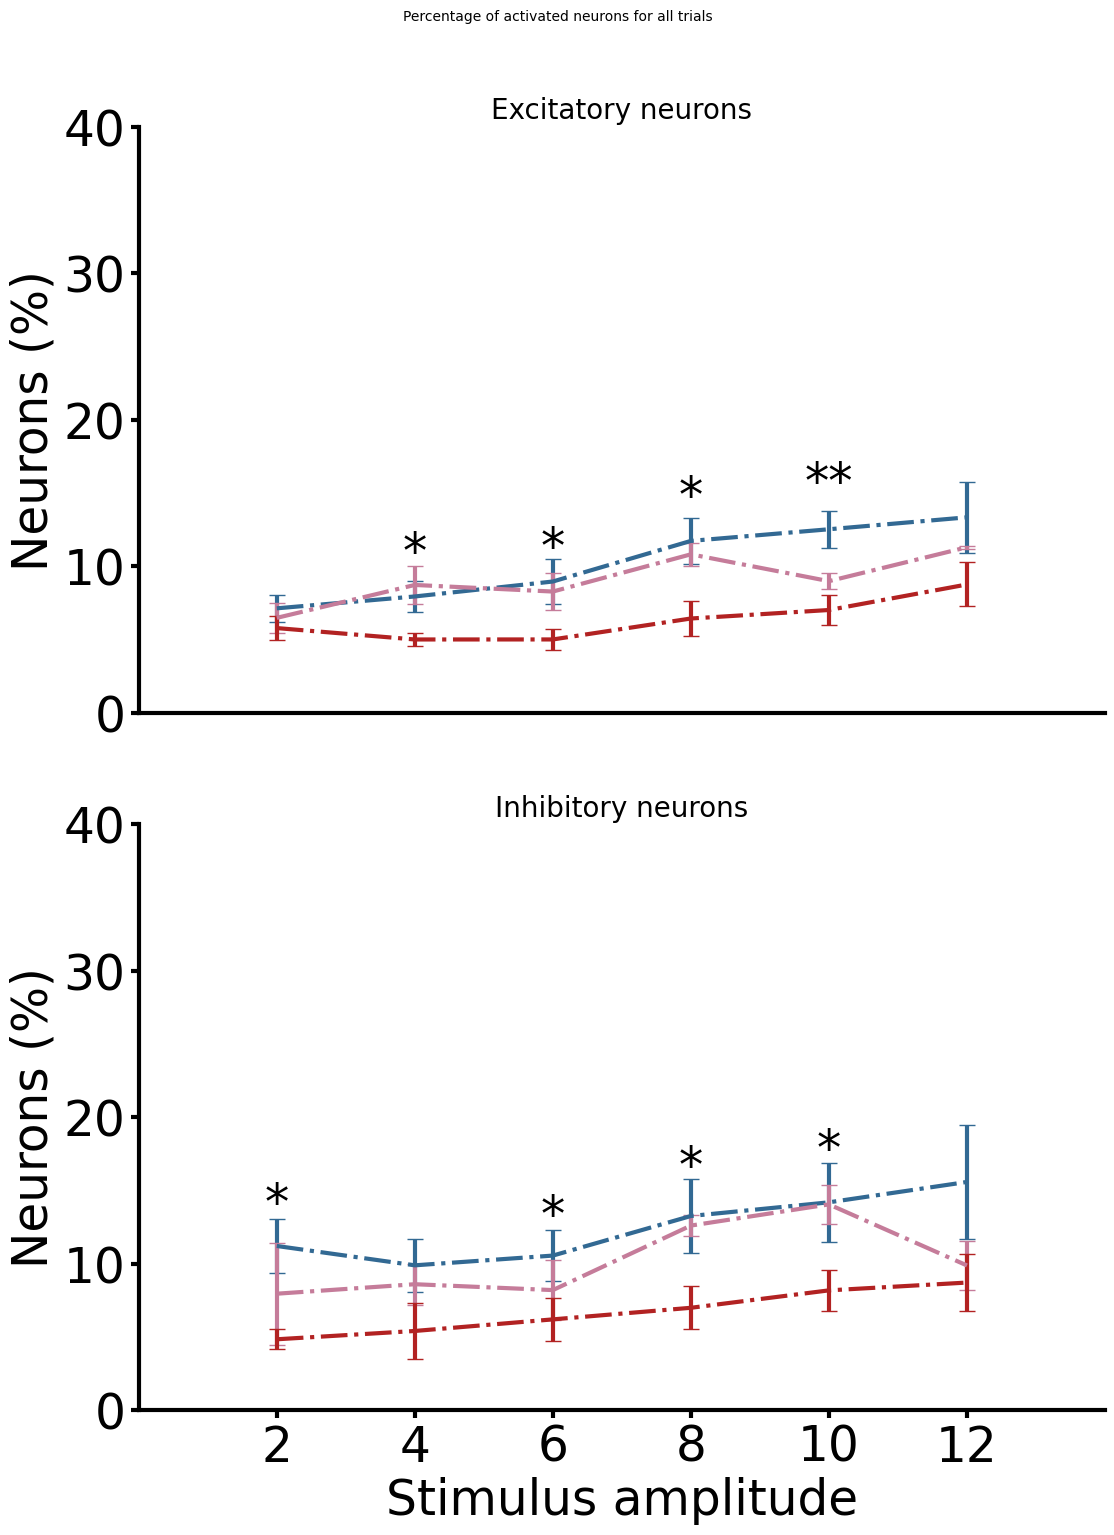

In [51]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "*", "*", "*", "**", "n.s"], ["*", "n.s", "*", "*", "*", "n.s"]])

In [ ]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

In [ ]:
plot_neuron_perc_amp(recs, pattern="activated", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of recruited neurons per amplitude

In [ ]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "*", "*", "*", "**", "n.s"], 
                                                                                                                                       ["n.s", "*", "n.s", "*", "*", "n.s"]])

In [ ]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

In [ ]:
plot_neuron_perc_amp(recs, pattern="recruited", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of inhibited neurons per amplitude

In [ ]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=True, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

In [ ]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=True, undetected_trials=False, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

In [ ]:
plot_neuron_perc_amp(recs, pattern="inhibited", detected_trials=False, undetected_trials=True, ylim=[0, 40], signif=True, sign_exc_inh=[["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"], ["n.s", "n.s", "n.s", "n.s", "n.s", "n.s"]])

## Graph of amplitude response from each stimulus amplitude


In [ ]:
figs, axs = plt.subplots(2,1,figsize=(12,16))

amps=[2,4,6,8,10,12]
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        rec.peak_delay_amp()
        mat = np.array(rec.matrices[type]["Peak_amplitude"])
        mat[mat<0]=np.nan

        _p=[]
        for amp in amps:
            trials = mat[:,rec.stim_ampl==amp]
            output = np.nanmean(np.nanmean(trials, axis=1))
            if np.isnan(output ):
                output = 0
            _p.append( output)
            
        if rec.genotype == "WT":
            wt.append(_p)

        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(_p)
        elif rec.genotype =="KO":
            ko.append(_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].grid(False)
    axs[i].set_facecolor("white")
    axs[i].spines["left"].set_color("black")
    axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True)
    axs[i].set_ylabel("Response Amp \n (z-score)")
    axs[i].set_xlabel("Stimulus amplitude")
    axs[i].set_title(labels[type])
    axs[i].tick_params(axis='both')
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].set_ylim([0,6])
    axs[i].spines[['right', 'top',]].set_visible(False)
axs[0].get_xaxis().set_visible(False)
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/resp_amp_linegraph.pdf")

# Psychometric curves like graphs for fraction of resp neurons

Number of active neurons and behavior psychometric curves comparison animal by animals

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,35])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=20)

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 1] = 0
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    nb_trials= []
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
        nb_trials.append(len(rec.stim_ampl[rec.stim_ampl == amp]))
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    # ax.bar([0, 2, 4, 6, 8, 10, 12], nb_trials)
    ax.set_title(title)
    ax.set_ylim([0,50])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=20)

percentage of neurons recruited for UNDETECTED TRIALS

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])

            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()

fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=20)

# Signal-to-Noise ratio (nb of neurons due to stimulus vs nb of neurons bsl) 


In [14]:
def SNR( pattern, n_type, ko, stim_ampl="all"):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_detected = resp_mat[:,ampl_det_filt]
        trials_undetected = resp_mat[:,ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0

        recruited_det = np.count_nonzero(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if  n_type== "INH":
            total_n = len(rec.zscore_inh)
        n_baseline = np.mean(np.count_nonzero(resp_mat[:,rec.stim_ampl==0],axis=0))
        # snr_det = (((np.mean(recruited_det)-n_baseline)/total_n)*100)  # option 1
        snr_det = np.mean(recruited_det)/n_baseline   # option 2
        #undetected
        recruited_undet = np.count_nonzero(trials_undetected,axis=0)
        # snr_undet =(((np.mean(recruited_undet)-n_baseline)/total_n)*100)  # option 1
        snr_undet = np.mean(recruited_undet)/n_baseline  # option 2

        if rec.genotype == "WT":
            wt_det.append(snr_det)
            wt_undet.append(snr_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
    return wt_det, ko_det, wt_undet, ko_undet

Boxplot plotting.
--- SNR ---
ShapiroResult(statistic=0.807174263167681, pvalue=0.024652398629680158)
ShapiroResult(statistic=0.8332659464260771, pvalue=0.08591517423560602)
MannwhitneyuResult(statistic=46.0, pvalue=0.14160839160839161)
Boxplot plotting.
--- SNR ---
ShapiroResult(statistic=0.8100061759565826, pvalue=0.02654974510126748)
ShapiroResult(statistic=0.6702677565872812, pvalue=0.0017404353382565964)
MannwhitneyuResult(statistic=36.0, pvalue=0.6805944055944056)


TypeError: fraction_resp() got an unexpected keyword argument 'ko'

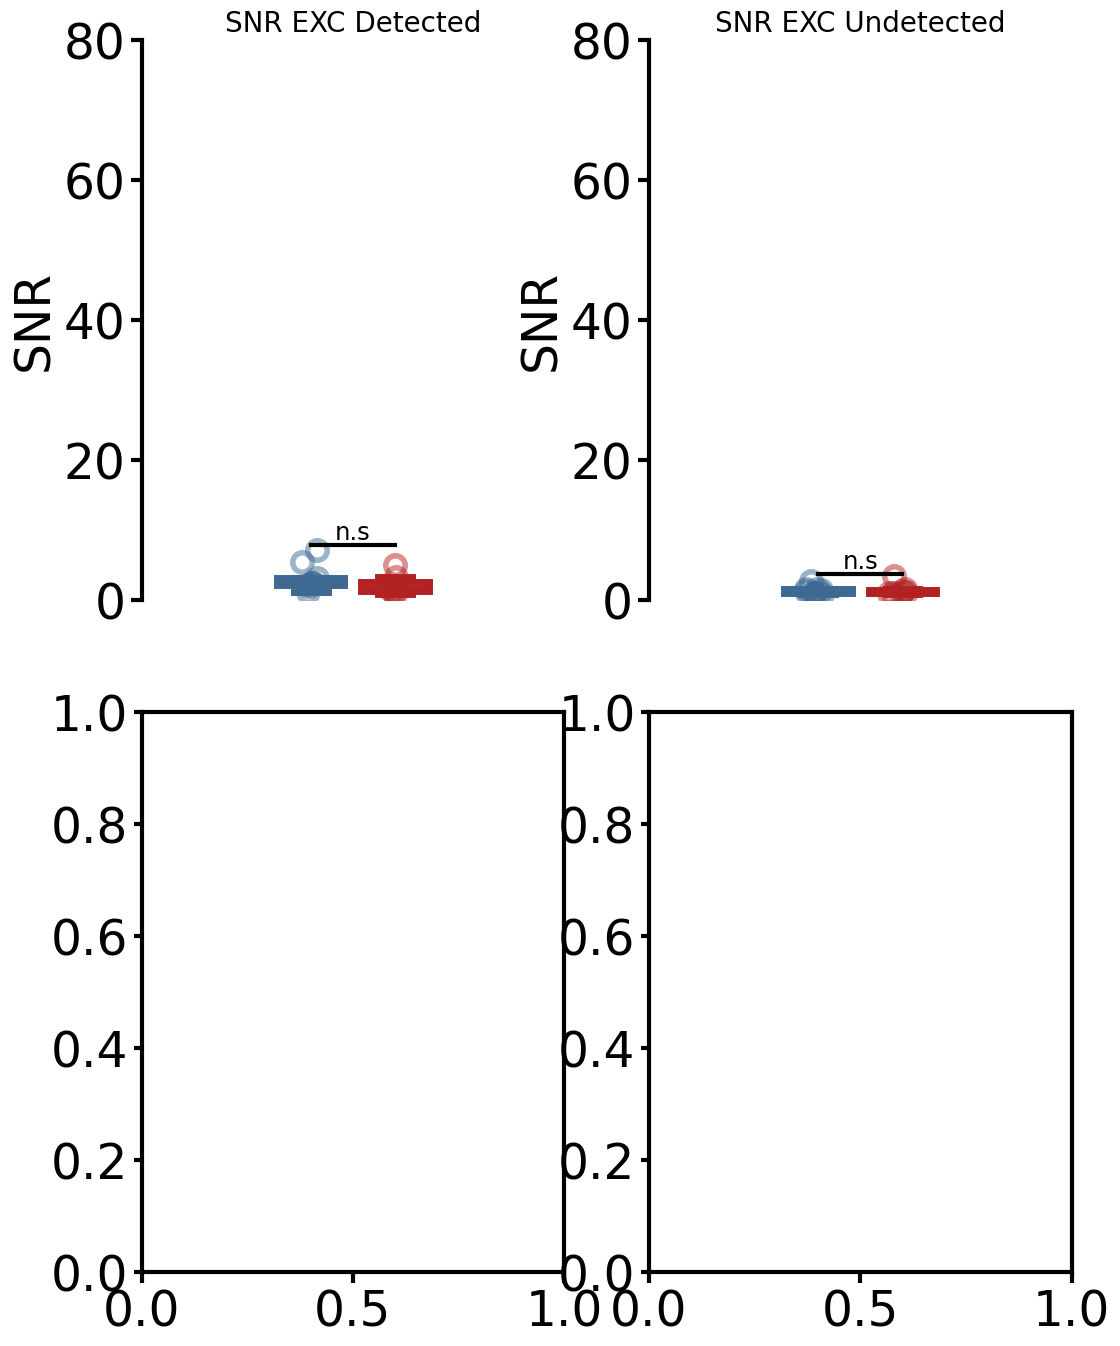

In [15]:
    wt_det, ko_det, wt_undet, ko_undet = SNR(pattern=0, n_type="EXC", ko="KO-hypo", stim_ampl="all")
    fig, axs = plt.subplots(2, 2, figsize=(12,16))
    ylim= [0,70]
    ppt.boxplot(axs[0, 0], wt_det,ko_det,"SNR",ylim=ylim)
    axs[0, 0].set_title("SNR EXC Detected")
    ppt.boxplot(axs[0, 1], wt_undet,ko_undet,"SNR",ylim=ylim)
    axs[0, 1].set_title("SNR EXC Undetected")
    wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=0, n_type="INH", ko="ko-hypo", stim_ampl="all")
    ppt.boxplot(axs[1, 0], wt_det1,ko_det1,"SNR",ylim=ylim)
    axs[1, 0].set_title("SNR INH Detected")
    ppt.boxplot(axs[1, 1], wt_undet1,ko_undet1,"SNR",ylim=ylim)
    axs[1, 1].set_title("SNR INH Undetected")
    fig.tight_layout()
    fig.savefig(server_address + "Figure2/responsivity/SNR.pdf")

# Fraction of neurons active during no-Gos

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9106459544006728, pvalue=0.32042181603225645)
ShapiroResult(statistic=0.9794650479087065, pvalue=0.956901077508393)
LeveneResult(statistic=0.4359231599782149, pvalue=0.5198126667866313)
Equal variances :TtestResult(statistic=0.00571420925200509, pvalue=0.9955213722624772, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9106459544006728, pvalue=0.32042181603225645)
ShapiroResult(statistic=0.9609547138596662, pvalue=0.8268827265491174)
LeveneResult(statistic=0.6534107433051941, pvalue=0.4324178040049804)
Equal variances :TtestResult(statistic=-0.10496124188357432, pvalue=0.9178955293599518, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9181033068721047, pvalue=0.37676793401169245)
ShapiroResult(statistic=0.9778559384840663, pvalue=0.9484993384310799)
LeveneResult(statistic=0.2910605248950572, pvalue=0.598018159825606)
Equal variances :TtestResult(statistic=0.024121467679927237

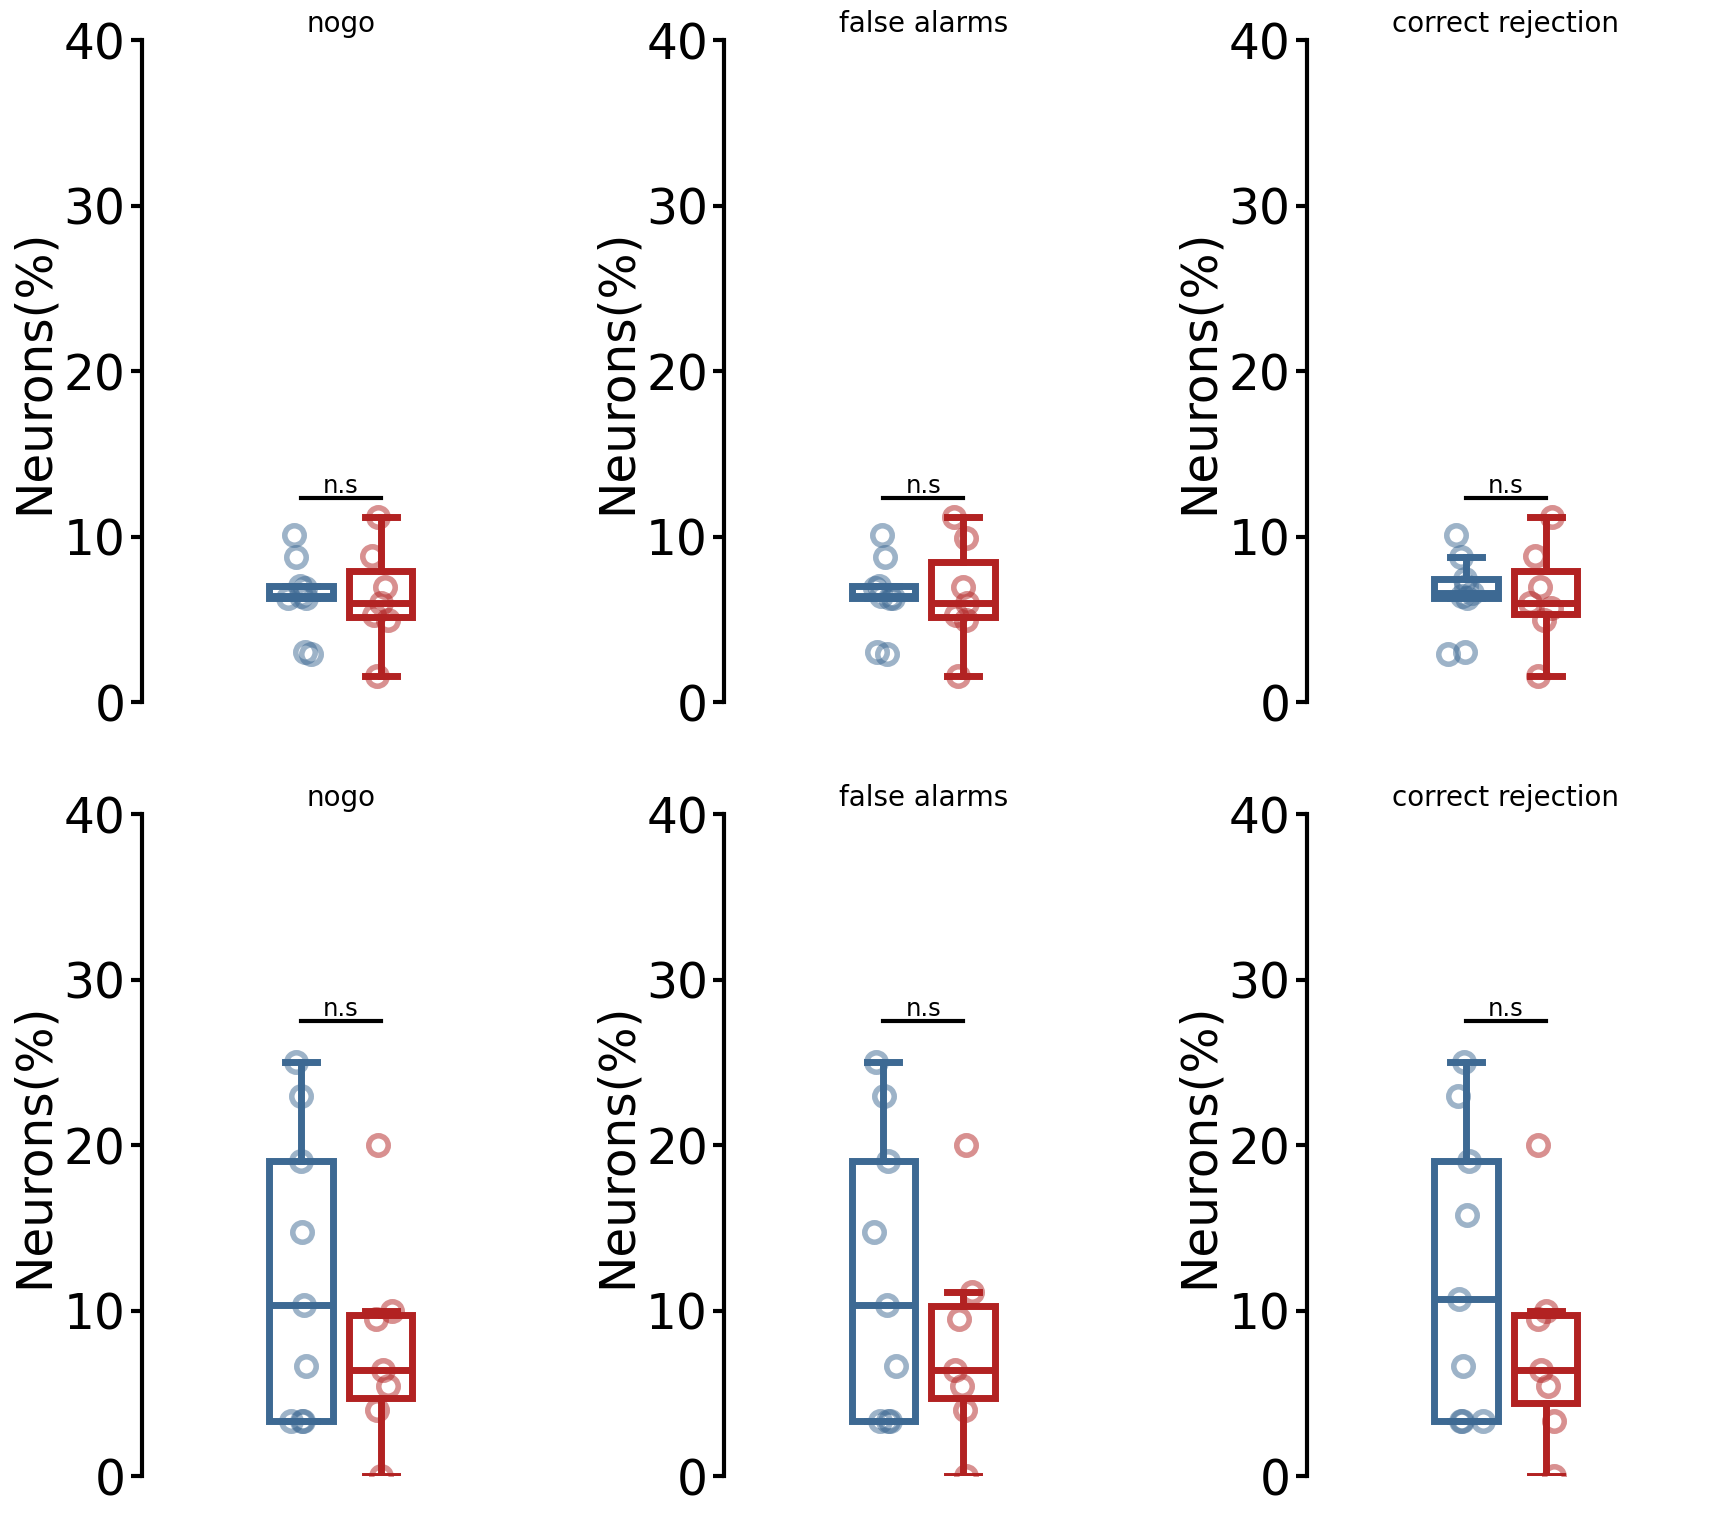

In [16]:
def nogo_fraction(pattern, n_type, ko, fa_cr_discrimination=True, return_fa=True):
    wt_det, wt_undet, ko_det, ko_undet = [], [], [], []
    
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = rec.matrices["EXC"]["Responsivity"]
        total_n = len(rec.zscore_exc)
        if n_type == "INH":
            resp_mat = rec.matrices["INH"]["Responsivity"]
            total_n = len(rec.zscore_inh)

        if fa_cr_discrimination:
            fa_timing, cr_timing, fa_timing1, cr_timing1 = [],[],[],[]
            no_go_timing = rec.stim_time[rec.stim_ampl==0]
            for i in no_go_timing:
                for y in rec.lick_time:
                    if y-i<30:
                        fa_timing.append(i)
                    else:    
                        cr_timing.append(i)
            n_baseline_fa = (np.mean(np.count_nonzero(resp_mat[:, np.isin(rec.stim_time, fa_timing)], axis=0)) / total_n) * 100          
            n_baseline_cr = (np.mean(np.count_nonzero(resp_mat[:, np.isin(rec.stim_time, cr_timing)], axis=0)) / total_n) * 100   
            
            if return_fa:
                n_baseline = n_baseline_fa
            else:
                n_baseline = n_baseline_cr
        else:
            n_baseline = (np.mean(np.count_nonzero(resp_mat[:, rec.stim_ampl == 0], axis=0)) / total_n) * 100
            
        if rec.genotype == "WT":
            wt_det.append(n_baseline)
        elif rec.genotype == "KO-Hypo":
            ko_det.append(n_baseline)

        elif rec.genotype == "KO" and ko == "KO":
            ko_det.append(n_baseline)

    return wt_det, ko_det

wt_exc_nogo, ko_exc_nogo = nogo_fraction(pattern=0, n_type="EXC", ko="KO-hypo", fa_cr_discrimination=False)
wt_exc_fa, ko_exc_fa = nogo_fraction(pattern=0, n_type="EXC", ko="ko-hypo", fa_cr_discrimination=True, return_fa=True)
wt_exc_cr, ko_exc_cr = nogo_fraction(pattern=0, n_type="EXC", ko="ko-hypo", fa_cr_discrimination=True, return_fa=False)
wt_inh_nogo, ko_inh_nogo = nogo_fraction(pattern=0, n_type="INH", ko="ko-hypo", fa_cr_discrimination=False)
wt_inh_fa, ko_inh_fa = nogo_fraction(pattern=0, n_type="INH",ko="ko-hypo", fa_cr_discrimination=True, return_fa=True)
wt_inh_cr, ko_inh_cr = nogo_fraction(pattern=0, n_type="INH", ko="ko-hypo", fa_cr_discrimination=True, return_fa=False)
fig, axs = plt.subplots(2, 3, figsize=(18, 16))
ylim = [0, 40]
ppt.boxplot(axs[0,0], wt_exc_nogo, ko_exc_nogo, "Neurons(%)", ylim=ylim)
ppt.boxplot(axs[0,1], wt_exc_fa, ko_exc_fa, "Neurons(%)", ylim=ylim)
ppt.boxplot(axs[0,2], wt_exc_cr, ko_exc_cr, "Neurons(%)", ylim=ylim)
axs[0,0].set_title("nogo")
axs[0,1].set_title("false alarms")
axs[0,2].set_title("correct rejection")
ppt.boxplot(axs[1,0], wt_inh_nogo, ko_inh_nogo, "Neurons(%)", ylim=ylim)
ppt.boxplot(axs[1,1], wt_inh_fa, ko_inh_fa, "Neurons(%)", ylim=ylim)
ppt.boxplot(axs[1,2], wt_inh_cr, ko_inh_cr, "Neurons(%)", ylim=ylim)
axs[1,0].set_title("nogo")
axs[1,1].set_title("false alarms")
axs[1,2].set_title("correct rejection")
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/nogo.pdf")

# Level of inhibition (nb of exc inhibited/ nb of inh activated) (No nogo normalization)

In [17]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type="EXC", ko=False, stim_ampl="all",
                                                   no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko=False, stim_ampl="all",
                                                       no_go_normalize=False)
wt_nan = np.logical_and(wt_det1>0,wt_undet1>0)
ko_nan = np.logical_and(ko_det1>0,ko_undet1>0)
wt_det, ko_det, wt_undet, ko_undet = wt_det[wt_nan], ko_det[ko_nan], wt_undet[wt_nan], ko_undet[ko_nan]
wt_det1, ko_det1, wt_undet1, ko_undet1 = wt_det1[wt_nan], ko_det1[ko_nan], wt_undet1[wt_nan], ko_undet1[ko_nan]
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
ylim = [0, 2]
ppt.boxplot(axs[0], np.divide(wt_det, wt_det1), np.divide(ko_det, ko_det1), "Level of inhibition", ylim=ylim)
axs[0].set_title("Detected")
ppt.boxplot(axs[1], np.divide(wt_undet, wt_undet1), np.divide(ko_undet, ko_undet1), "Level of inhibition", ylim=ylim)
axs[1].set_title("Undetected")
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/inhbib_level.pdf")

TypeError: fraction_resp() got an unexpected keyword argument 'ko'

# E/I ratio 

In [ ]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type="EXC", ko=False, stim_ampl="all", no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko=False, stim_ampl="all", no_go_normalize=False)

ylim =[0,4]
fig, axs = plt.subplots(1, 2, figsize=(12,8))
y0=np.round(np.divide(wt_det,wt_det1),3)
y1=np.round(np.divide(ko_det,ko_det1),3)
ppt.boxplot(axs[0],y0 ,y1,"E/I ratio",ylim=ylim)
axs[0].set_title("Detected")
y2=np.round(np.divide(wt_undet,wt_undet1),3)
y3=np.round(np.divide(ko_undet,ko_undet1),3)
ppt.boxplot(axs[1],y2[np.isfinite(y2)], y3[np.isfinite(y3)],"E/I ratio",ylim=ylim)
axs[1].set_title("Undetected")
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/EI_ratio.pdf")


# Nb and percentage of neurons in the fields of view

In [ ]:
def quantify_neur(n_type, ko="all"):
    wt_n, ko_n, wt_per, ko_per = [],[],[],[]
    for rec in recs.values():
        if n_type == "EXC":
            n_neur = rec.zscore_exc.shape[0]
            n_perc = (rec.zscore_exc.shape[0]/(rec.zscore_exc.shape[0]+rec.zscore_inh.shape[0]))*100

        elif n_type == "INH":
            n_neur = rec.zscore_inh.shape[0]
            n_perc = (rec.zscore_inh.shape[0]/(rec.zscore_inh.shape[0]+rec.zscore_exc.shape[0]))*100

        if rec.genotype == "WT":
            wt_n.append(n_neur)
            wt_per.append(n_perc)
        elif rec.genotype =="KO-Hypo":
            ko_n.append(n_neur)
            ko_per.append(n_perc)
        elif rec.genotype == "KO" and ko =="KO":
            ko_n.append(n_neur)
            ko_per.append(n_perc)

    return wt_n, ko_n, wt_per, ko_per

In [ ]:
quantify_neur("EXC")

In [ ]:
wt_exc, ko_exc, wt_per_e, ko_per_e = quantify_neur("EXC",ko="KO-hy")
wt_inh, ko_inh, wt_per_i, ko_per_i = quantify_neur("INH",ko="KO-hypo")
fig, axs = plt.subplots(2, 2, figsize=(12,16))
ppt.boxplot(axs[0,0],wt_exc ,ko_exc,"Nb Neurons exc",ylim=[0, 150])
ppt.boxplot(axs[0,1],wt_inh ,ko_inh,"Nb Neurons inh",ylim=[0, 150])
ppt.boxplot(axs[1,0],wt_per_e ,ko_per_e,"% Neurons exc",ylim=[0, 100])
ppt.boxplot(axs[1,1],wt_per_i ,ko_per_i,"% Neurons inh",ylim=[0, 100])
fig.tight_layout()
fig.savefig(server_address + "Figure2/responsivity/neurons_field_of_view.pdf")
